In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# TL;DR

| Model                                       | R-squared (train)  | R-squared (val)    | R-squared (test)   | R-absolute (train) | R-absolute (val)   | R-absolute (test)  |
|---------------------------------------------|--------------------|--------------------|--------------------|--------------------|--------------------|--------------------|
| Linear regression                           | 0.5169866          |                    | 0.4549708          | 0.3383185          |                    | 0.3255524          |
| Lasso                                       | 0.5166027          |                    | 0.4613136          | 0.3371221          |                    | 0.3272954          |
| LARS                                        | 0.5160043          |                    | 0.4642462          | 0.3359979          |                    | 0.3276234          |
| Polynomial regression                       | 0.6010396          |                    | 0.5301241          | 0.3994169          |                    | 0.3740960          |
| Linear regression with RFE (6 features)     | 0.5160676          |                    | 0.4575793          | 0.3379842          |                    | 0.3255046          |
| Polynomial regression with RFE (5 features) | 0.4552918          |                    | 0.4691225          | 0.2864168          |                    | 0.3326174          |
| CrossNet                                    | 0.6884830          | 0.2226251          | 0.5017266          | 0.4879999          | 0.1206011          | 0.3968694          |
| MLP                                         | 0.9980898          | 0.1031491          | 0.2870642          | 0.9613156          | 0.1044721          | 0.2413247          |
| XGBoost                                     | 0.6163958          | 0.3052738          | 0.4813085          | 0.4093728          | 0.1779834          | 0.3262125          |
| EBM                                         | 0.6947590          | 0.4140548          | 0.4582469          | 0.4723313          | 0.2118888          | 0.3200194          |
| NAM                                         | 0.4631733          | 0.4038129          | 0.4546912          | 0.2804932          | 0.1968498          | 0.2907707          |
| NODE GAM                                    | 0.6060284          | 0.6050312          | 0.4252885          | 0.4231943          | 0.3740149          | 0.3055096          |
| NODE GA2M                                   | 0.4647184          | 0.4057951          | 0.3696757          | 0.3209596          | 0.3050901          | 0.2833377          |
| HONAM                                       | 0.9932572          | -1.1341181         | -0.7910015         | 0.9315096          | -0.3565330         | -0.2370180         |


# TODO in report
- add y transformation in methodology
- add info about batch size

- https://hastie.su.domains/Papers/LARS/LeastAngle_2002.pdf
- http://rstudio-pubs-static.s3.amazonaws.com/358961_ddc67a63195d43ed981b81f5bed43884.html
- https://strimmerlab.github.io/software/care/download/diabetes.pdf
- http://garthtarr.github.io/mplot/articles/diabetes.html
- https://github.com/federico-trotta/predicting_diabetes_with_ML
- LARS


In [2]:
import numpy as np
import pandas as pd
import torch
from utils import evaluate
from outliers import outliers_box

## Dataset

[Link to dataset](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html)

In [52]:
df = pd.read_csv('./data/diabetes_data.csv')
df.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,y
0,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80,135


In [ ]:
df.describe()

In [ ]:
df.applymap(lambda x: x == 0).sum()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 15))

mask = np.triu(np.ones_like(df.corr()))
ax = plt.axes()
sns.heatmap(df.corr(), annot=True, fmt='.2f', mask=mask, cmap="RdYlGn", vmin=-1, vmax=1, )
ax.set_title('Correlation matrix for raw diabetes progression data')
plt.show()

In [ ]:
import plotly.express as px
fig = px.scatter(df, x="tc", y="ldl", color='y', color_continuous_scale='rdylgn', labels={'tc': 'total serum cholesterol', 'ldl': 'low-density lipoprotein', 'y': 'disease progression 1 year after baseline'},
                 title='Correlation between low-density lipoprotein (ldl) and total serum cholesterol (tc)', height=1200, width=2400, trendline='ols')
fig.show()

In [ ]:
import plotly.express as px
fig = px.scatter(df, x="tch", y="hdl", color='y', color_continuous_scale='rdylgn', labels={'tch': 'total cholesterol', 'hdl': 'high-density lipoprotein', 'y': 'disease progression 1 year after baseline'},
                 title='Correlation between high-density lipoprotein (hdl) and total cholesterol (tch)', height=1200, width=2400, trendline='ols', trendline_options={'log_x': True, 'log_y': True})
fig.show()

In [ ]:
import plotly.figure_factory as ff
fig = ff.create_scatterplotmatrix(df, diag='histogram', size=3, title='Pairwise correltation in raw diabetes progression data', height=1200, width=2400)
for fig_data in fig.data:
    fig_data['marker']['color'] = '#1f77b4'
fig.show()

### Quantile transformation comparison

In [ ]:
from plotly.subplots import make_subplots

from sklearn.preprocessing import QuantileTransformer, StandardScaler
import plotly.figure_factory as ff

transformer = QuantileTransformer(output_distribution='normal', n_quantiles=df.shape[0])
scaler = StandardScaler()
var = 'y'
trans = transformer.fit_transform(df[[var]])
scaled = scaler.fit_transform(df[[var]])
trans_scaled = scaler.fit_transform(trans)

fig = ff.create_distplot([scaled.ravel(), trans_scaled.ravel()], ['Without Quantile Transformation', 'With Quantile Transformation'], show_hist=False, bin_size=0.01, show_curve=True, show_rug=False)
fig.update_layout(title_text=f'{var}')
fig.update_yaxes(range=[0, 1])
fig.update_xaxes(range=[-5, 5])
fig.show()

# Data pre-processing

In [72]:
from load_data import load_diabetes_data
columns, (x_raw_train, y_raw_train), (x_raw_val, y_raw_val), (x_raw_test, y_raw_test) = load_diabetes_data()
print('COLUMNS: ', columns)
print('training set: ', x_raw_train.shape, y_raw_train.shape)
print('validation set: ', x_raw_val.shape, y_raw_val.shape)
print('test set: ', x_raw_test.shape, y_raw_test.shape)

COLUMNS:  ['age', 'sex', 'bmi', 'map', 'tc', 'ldl', 'hdl', 'tch', 'ltg', 'glu']
training set:  (266, 10) (266, 1)
validation set:  (88, 10) (88, 1)
test set:  (88, 10) (88, 1)


In [73]:
task = 'regression'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = int(np.ceil(x_raw_train.shape[0] / 100))
print(f'task={task}: device is {device} and batch size is {batch_size}')

task=regression: device is cpu and batch size is 3


In [74]:
from load_data import load_diabetes_data
from preprocessor import Preprocessor

preprocessor = Preprocessor(task=task, n_quantiles=x_raw_train.shape[0])
x_train, y_train = preprocessor.fit_transform(x_raw_train, y_raw_train)
x_val, y_val = preprocessor.transform(x_raw_val, y_raw_val)
x_test, y_test = preprocessor.transform(x_raw_test, y_raw_test)

# Baselining

## Statsmodel

In [8]:
labels = {
  "age": "age",
  "sex": "sex",
  "bmi": "body mass index",
  "map": "average blood pressure",
  "tc": "total serum cholesterol",
  "ldl": "low-density lipoprotein",
  "hdl": "high-density lipoprotein",
  "tch": "total cholesterol",
  "ltg": "lamotrigine",
  "glu": "glucose",
  "y": "disease progression one year after baseline"
}

In [187]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

def get_lr_local_interpretation(index, y_hat, feature_weights):
    x = x_test[index]
    feature_influence = x * feature_weights
    x_true = preprocessor.inverse_transform_x([x])[0]
    y_true = preprocessor.inverse_transform_y([y_test[index]])[0][0]
    y_pred = preprocessor.inverse_transform_y([[y_hat]])[0][0]
    y_mean = preprocessor.inverse_transform_y([[0]])[0][0]

    df = pd.DataFrame(np.stack([x, x_true, feature_weights, feature_influence]), columns=columns).T.reset_index()
    df.columns = ['variable', 'scaled', 'original', 'feature_weights', 'feature_contribution']
    df['variable'] = df['variable'].apply(lambda x: labels[x])

    return df, int(y_true), y_pred, y_mean

def plot_local_interpretation(df, title):
    df['variable_val'] = df.apply(lambda r: f"{r['variable']}<br>({int(r['original']) if r['original'].is_integer() else round(r['original'], 2)})", axis=1)

    fig = make_subplots(rows=1, cols=2, shared_yaxes=True, subplot_titles=("Feature contribution","Values of features and output relative to the mean"))

    fig.add_trace(go.Bar(x=df['feature_contribution'], y=df['variable'], orientation='h', text=df['variable'], showlegend=False, marker={'color':'#1f77b4'}), row=1, col=1)
    fig.add_trace(go.Bar(x=df['scaled'], y=df['variable'], orientation='h', text=df['variable_val'], showlegend=False, marker={'color':['#1f77b4' for i in range(10)] + ['#bcbd22', '#2ca02c']}, textposition='auto'),row=1, col=2)
    if 'feature_weights' in df.columns:
        fig.add_trace(go.Bar(x=df['feature_weights'], y=df['variable'], orientation='h', showlegend=False, marker={'color':'#17becf'}),row=1, col=2)

    fig.update_layout(title_text=title, height=800)
    fig.update_yaxes(visible=False, showticklabels=False)
    fig['layout']['xaxis1'].update(range=[-0.5,0.5], showgrid=False)
    fig['layout']['xaxis2'].update(range=[-2,2], showgrid=False)
    fig['layout'].update(barmode='relative')
    
    return fig

## Linear regression

In [120]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(x_train, y_train)
lr_fit = lr.predict(x_train)
lr_pred = lr.predict(x_test)

print("TRAIN: ", evaluate(y_train, lr_fit, task))
print("TEST: ", evaluate(y_test, lr_pred, task))
lr_weights = pd.DataFrame([(col, coefficient) for col, coefficient in zip(columns, lr.coef_[-1])], columns=['variable', 'coefficient'])
lr_weights['variable'] = lr_weights['variable'].apply(lambda x: labels[x])
lr_weights.sort_values(by='coefficient', key=abs, ascending=False)

TRAIN:  (0.4835605991369081, 0.31706055160130386)
TEST:  (0.4153718035046221, 0.27259523421109166)


,variable,coefficient
2,body mass index,0.323797
6,high-density lipoprotein,-0.279573
3,average blood pressure,0.248764
8,lamotrigine,0.195404
1,sex,-0.155652
4,total serum cholesterol,0.138189
5,low-density lipoprotein,-0.128874
7,total cholesterol,-0.056285
9,glucose,0.019193
0,age,-0.007005


In [121]:
import plotly.express as px
fig = px.bar(lr_weights, y='variable', x='coefficient', orientation='h', range_x=(-0.5, 0.5), text='variable', title='Global interpretation of Linear Regression', height=800, width=800, labels={'coefficient': 'feature importance'})
fig.update_yaxes(visible=False, showticklabels=False)
fig.update_xaxes(showgrid=False)
fig.show()

In [122]:
true_negative = 74
false_negative = 46
true_positive = 76
false_positive = 61

In [188]:
_d, true, pred, mean = get_lr_local_interpretation(true_negative, lr_pred[true_negative][0], lr.coef_[-1])
fig = plot_local_interpretation(_d, f'Local interpretation of Linear Regression for a sample where ACTUAL={true} | PREDICTED={pred:.2f} | MEAN={mean:.2f}')
fig.show()

In [189]:
_d, true, pred, mean = get_lr_local_interpretation(false_negative, lr_pred[false_negative][0], lr.coef_[-1])
fig = plot_local_interpretation(_d, f'Local interpretation of Linear Regression for a sample where ACTUAL={true} | PREDICTED={pred:.2f} | MEAN={mean:.2f}')
fig.show()

In [190]:
_d, true, pred, mean = get_lr_local_interpretation(true_positive, lr_pred[true_positive][0], lr.coef_[-1])
fig = plot_local_interpretation(_d, f'Local interpretation of Linear Regression for a sample where ACTUAL={true} | PREDICTED={pred:.2f} | MEAN={mean:.2f}')
fig.show()

In [191]:
_d, true, pred, mean = get_lr_local_interpretation(false_positive, lr_pred[false_positive][0], lr.coef_[-1])
fig = plot_local_interpretation(_d, f'Local interpretation of Linear Regression for a sample where ACTUAL={true} | PREDICTED={pred:.2f} | MEAN={mean:.2f}')
fig.show()

## Lasso regression

## LARS

## Polynomial regression

## Linear regression with recursive feature elimination

## Polynomial regression with recursive feature elimination

## Comparison of all linear models

### Experiment configuration
- linear/logistic regression
- CrossNet (Wang et al. 2017)
  - number of units: 32
- XGBoost (Chen and Guestrin 2016)
  - number of boosting rounds: 1000
  - eta: 0.3
- EBM (Nori et al. 2019)
  - number of boosting rounds: 20000
  - inner bags: 8
  - outer bags: 8
  - learning rate: 0.01
- MLP
  - hidden layers: 3
  - hidden units: [32, 64, 32]
  - activation function: LeakyReLU
- NAM (Agarwal et al. 2020)
  - hidden layers: 3
  - hidden units: [32, 64, 32]
  - activation function: LeakyReLU
- NodeGAM (Chang, Caruana, and Goldenberg 2022), NodeGA2M
  - default hyperparameters provided by (Chang, Caruana, and Goldenberg 2022)
- HONAM
  - hidden layers: 3
  - hidden units: [32, 64, 32]
  - activation function: LeakyReLU
  
- epochs: 1000
- learning rate: 0.001
- batch size = (number of data samples)/100
- trained with 5 random seeds
- mean scores with standard deviations reported

## CrossNet
[deepctr-torch](https://deepctr-torch.readthedocs.io/en/latest/index.html)

In [82]:
from deepctr_torch.inputs import DenseFeat
from deepctr_torch.models import DCN

feature_columns = [DenseFeat(col, 1) for col in columns]

train_model_input = dict(zip(columns, x_train.T))
val_model_input = dict(zip(columns, x_val.T))
test_model_input = dict(zip(columns, x_test.T))
    
dcn = DCN(linear_feature_columns=feature_columns, dnn_feature_columns=feature_columns, dnn_hidden_units=[16, 32, 16], dnn_dropout=0.5, l2_reg_linear=0.0001, l2_reg_embedding=0.0001, l2_reg_cross=0.0001, l2_reg_dnn=0.2, task='regression', device=device)
dcn.compile("adam", "mse", metrics=['mse'])
dcn.fit(train_model_input, y_train, validation_data=(val_model_input, y_val), epochs=1000)

cpu
Train on 266 samples, validate on 88 samples, 2 steps per epoch


2it [00:00, 194.85it/s]


Epoch 1/1000
0s - loss:  11.3100 - mse:  9.6216 - val_mse:  3.8805


2it [00:00, 185.84it/s]


Epoch 2/1000
0s - loss:  10.7489 - mse:  7.0470 - val_mse:  3.7456


2it [00:00, 158.77it/s]


Epoch 3/1000
0s - loss:  10.2563 - mse:  6.2090 - val_mse:  3.6218


2it [00:00, 201.21it/s]


Epoch 4/1000
0s - loss:  9.7994 - mse:  5.5220 - val_mse:  3.5050


2it [00:00, 184.26it/s]


Epoch 5/1000
0s - loss:  9.3681 - mse:  5.2374 - val_mse:  3.3940


2it [00:00, 181.71it/s]


Epoch 6/1000
0s - loss:  8.9586 - mse:  5.1037 - val_mse:  3.2884


2it [00:00, 207.92it/s]


Epoch 7/1000
0s - loss:  8.5685 - mse:  5.0318 - val_mse:  3.1878


2it [00:00, 248.42it/s]


Epoch 8/1000
0s - loss:  8.1983 - mse:  4.7229 - val_mse:  3.0918


2it [00:00, 202.21it/s]


Epoch 9/1000
0s - loss:  7.8349 - mse:  9.3796 - val_mse:  3.0005


2it [00:00, 202.97it/s]


Epoch 10/1000
0s - loss:  7.5088 - mse:  4.8676 - val_mse:  2.9132


2it [00:00, 213.47it/s]


Epoch 11/1000
0s - loss:  7.1885 - mse:  4.9667 - val_mse:  2.8299


2it [00:00, 188.66it/s]


Epoch 12/1000
0s - loss:  6.8835 - mse:  4.2589 - val_mse:  2.7507


2it [00:00, 236.32it/s]


Epoch 13/1000
0s - loss:  6.5940 - mse:  3.8356 - val_mse:  2.6752


2it [00:00, 210.62it/s]


Epoch 14/1000
0s - loss:  6.3115 - mse:  7.0924 - val_mse:  2.6035


2it [00:00, 199.44it/s]


Epoch 15/1000
0s - loss:  6.0574 - mse:  3.7020 - val_mse:  2.5353


2it [00:00, 195.98it/s]


Epoch 16/1000
0s - loss:  5.8084 - mse:  4.0543 - val_mse:  2.4706


2it [00:00, 230.84it/s]


Epoch 17/1000
0s - loss:  5.5731 - mse:  6.5195 - val_mse:  2.4088


2it [00:00, 224.87it/s]


Epoch 18/1000
0s - loss:  5.3495 - mse:  3.5896 - val_mse:  2.3515


2it [00:00, 207.28it/s]


Epoch 19/1000
0s - loss:  5.1377 - mse:  3.4092 - val_mse:  2.2976


2it [00:00, 273.00it/s]


Epoch 20/1000
0s - loss:  4.9392 - mse:  2.6762 - val_mse:  2.2462


2it [00:00, 237.53it/s]


Epoch 21/1000
0s - loss:  4.7473 - mse:  3.7657 - val_mse:  2.1978


2it [00:00, 203.27it/s]


Epoch 22/1000
0s - loss:  4.5700 - mse:  2.9215 - val_mse:  2.1519


2it [00:00, 229.83it/s]


Epoch 23/1000
0s - loss:  4.3992 - mse:  3.1149 - val_mse:  2.1084


2it [00:00, 227.35it/s]


Epoch 24/1000
0s - loss:  4.2370 - mse:  2.8196 - val_mse:  2.0670


2it [00:00, 194.21it/s]


Epoch 25/1000
0s - loss:  4.0800 - mse:  5.3885 - val_mse:  2.0283


2it [00:00, 206.20it/s]


Epoch 26/1000
0s - loss:  3.9403 - mse:  2.3360 - val_mse:  1.9913


2it [00:00, 209.77it/s]


Epoch 27/1000
0s - loss:  3.7990 - mse:  4.0572 - val_mse:  1.9560


2it [00:00,  6.97it/s]


Epoch 28/1000
0s - loss:  3.6694 - mse:  2.9339 - val_mse:  1.9224


2it [00:00, 204.02it/s]


Epoch 29/1000
0s - loss:  3.5459 - mse:  2.2750 - val_mse:  1.8906


2it [00:00, 177.97it/s]


Epoch 30/1000
0s - loss:  3.4253 - mse:  2.3710 - val_mse:  1.8605


2it [00:00, 199.44it/s]


Epoch 31/1000
0s - loss:  3.3118 - mse:  2.4746 - val_mse:  1.8320


2it [00:00, 214.98it/s]


Epoch 32/1000
0s - loss:  3.2019 - mse:  3.6826 - val_mse:  1.8049


2it [00:00, 211.17it/s]


Epoch 33/1000
0s - loss:  3.1017 - mse:  1.9747 - val_mse:  1.7793


2it [00:00, 231.35it/s]


Epoch 34/1000
0s - loss:  2.9754 - mse:  20.3151 - val_mse:  1.7560


2it [00:00, 214.83it/s]


Epoch 35/1000
0s - loss:  2.9114 - mse:  4.0399 - val_mse:  1.7335


2it [00:00, 205.34it/s]


Epoch 36/1000
0s - loss:  2.8247 - mse:  1.8219 - val_mse:  1.7121


2it [00:00, 231.69it/s]


Epoch 37/1000
0s - loss:  2.7382 - mse:  1.9537 - val_mse:  1.6919


2it [00:00, 259.74it/s]


Epoch 38/1000
0s - loss:  2.6567 - mse:  1.7021 - val_mse:  1.6730


2it [00:00, 228.28it/s]


Epoch 39/1000
0s - loss:  2.5782 - mse:  1.5399 - val_mse:  1.6553


2it [00:00, 216.59it/s]


Epoch 40/1000
0s - loss:  2.5039 - mse:  1.7259 - val_mse:  1.6388


2it [00:00, 216.34it/s]


Epoch 41/1000
0s - loss:  2.4329 - mse:  1.8994 - val_mse:  1.6235


2it [00:00, 207.02it/s]


Epoch 42/1000
0s - loss:  2.3653 - mse:  1.9143 - val_mse:  1.6091


2it [00:00, 127.90it/s]


Epoch 43/1000
0s - loss:  2.3011 - mse:  1.7805 - val_mse:  1.5955


2it [00:00, 85.96it/s]


Epoch 44/1000
0s - loss:  2.2387 - mse:  2.7142 - val_mse:  1.5833


2it [00:00, 137.75it/s]


Epoch 45/1000
0s - loss:  2.1821 - mse:  1.3781 - val_mse:  1.5716


2it [00:00, 205.38it/s]


Epoch 46/1000
0s - loss:  2.1264 - mse:  1.4700 - val_mse:  1.5606


2it [00:00, 240.88it/s]


Epoch 47/1000
0s - loss:  2.0734 - mse:  1.5135 - val_mse:  1.5503


2it [00:00, 201.43it/s]


Epoch 48/1000
0s - loss:  2.0231 - mse:  1.6136 - val_mse:  1.5406


2it [00:00, 226.37it/s]


Epoch 49/1000
0s - loss:  1.9744 - mse:  1.4481 - val_mse:  1.5310


2it [00:00, 221.80it/s]


Epoch 50/1000
0s - loss:  1.9283 - mse:  1.2311 - val_mse:  1.5217


2it [00:00, 207.51it/s]


Epoch 51/1000
0s - loss:  1.8841 - mse:  1.4371 - val_mse:  1.5126


2it [00:00, 235.43it/s]


Epoch 52/1000
0s - loss:  1.8419 - mse:  1.1875 - val_mse:  1.5038


2it [00:00, 249.97it/s]


Epoch 53/1000
0s - loss:  1.8012 - mse:  2.1786 - val_mse:  1.4952


2it [00:00, 251.77it/s]


Epoch 54/1000
0s - loss:  1.7616 - mse:  1.9162 - val_mse:  1.4864


2it [00:00, 219.83it/s]


Epoch 55/1000
0s - loss:  1.7257 - mse:  1.2980 - val_mse:  1.4769


2it [00:00, 210.86it/s]


Epoch 56/1000
0s - loss:  1.6898 - mse:  1.0388 - val_mse:  1.4675


2it [00:00, 205.18it/s]


Epoch 57/1000
0s - loss:  1.6556 - mse:  1.1945 - val_mse:  1.4581


2it [00:00, 212.20it/s]


Epoch 58/1000
0s - loss:  1.6223 - mse:  1.3631 - val_mse:  1.4487


2it [00:00, 189.29it/s]


Epoch 59/1000
0s - loss:  1.5910 - mse:  1.0949 - val_mse:  1.4399


2it [00:00, 137.50it/s]


Epoch 60/1000
0s - loss:  1.5605 - mse:  1.5400 - val_mse:  1.4313


2it [00:00, 198.16it/s]


Epoch 61/1000
0s - loss:  1.5313 - mse:  1.1739 - val_mse:  1.4224


2it [00:00, 233.26it/s]


Epoch 62/1000
0s - loss:  1.5026 - mse:  1.2134 - val_mse:  1.4137


2it [00:00, 218.08it/s]


Epoch 63/1000
0s - loss:  1.4757 - mse:  1.2717 - val_mse:  1.4049


2it [00:00, 278.02it/s]


Epoch 64/1000
0s - loss:  1.4492 - mse:  1.1380 - val_mse:  1.3959


2it [00:00, 219.98it/s]


Epoch 65/1000
0s - loss:  1.4240 - mse:  0.9385 - val_mse:  1.3869


2it [00:00, 238.27it/s]


Epoch 66/1000
0s - loss:  1.3990 - mse:  2.4811 - val_mse:  1.3782


2it [00:00, 218.94it/s]


Epoch 67/1000
0s - loss:  1.3770 - mse:  1.3655 - val_mse:  1.3703


2it [00:00, 196.04it/s]


Epoch 68/1000
0s - loss:  1.3544 - mse:  0.9295 - val_mse:  1.3627


2it [00:00, 208.59it/s]


Epoch 69/1000
0s - loss:  1.3330 - mse:  0.8777 - val_mse:  1.3549


2it [00:00, 265.36it/s]


Epoch 70/1000
0s - loss:  1.3119 - mse:  1.0939 - val_mse:  1.3475


2it [00:00, 251.19it/s]


Epoch 71/1000
0s - loss:  1.2920 - mse:  1.1866 - val_mse:  1.3400


2it [00:00, 215.88it/s]


Epoch 72/1000
0s - loss:  1.2726 - mse:  0.9758 - val_mse:  1.3324


2it [00:00, 225.59it/s]


Epoch 73/1000
0s - loss:  1.2540 - mse:  0.8308 - val_mse:  1.3249


2it [00:00, 208.57it/s]


Epoch 74/1000
0s - loss:  1.2358 - mse:  1.0483 - val_mse:  1.3178


2it [00:00, 206.27it/s]


Epoch 75/1000
0s - loss:  1.2185 - mse:  1.0288 - val_mse:  1.3109


2it [00:00, 208.95it/s]


Epoch 76/1000
0s - loss:  1.2018 - mse:  0.8750 - val_mse:  1.3037


2it [00:00, 246.31it/s]


Epoch 77/1000
0s - loss:  1.1856 - mse:  1.0190 - val_mse:  1.2968


2it [00:00, 227.33it/s]


Epoch 78/1000
0s - loss:  1.1700 - mse:  0.7783 - val_mse:  1.2897


2it [00:00, 202.22it/s]


Epoch 79/1000
0s - loss:  1.1548 - mse:  0.8714 - val_mse:  1.2826


2it [00:00, 227.56it/s]


Epoch 80/1000
0s - loss:  1.1403 - mse:  0.9101 - val_mse:  1.2758


2it [00:00, 205.05it/s]


Epoch 81/1000
0s - loss:  1.1261 - mse:  0.7690 - val_mse:  1.2696


2it [00:00, 205.97it/s]


Epoch 82/1000
0s - loss:  1.1124 - mse:  1.0141 - val_mse:  1.2638


2it [00:00, 211.01it/s]


Epoch 83/1000
0s - loss:  1.0993 - mse:  0.9567 - val_mse:  1.2575


2it [00:00, 202.80it/s]


Epoch 84/1000
0s - loss:  1.0865 - mse:  0.8271 - val_mse:  1.2511


2it [00:00, 131.67it/s]


Epoch 85/1000
0s - loss:  1.0741 - mse:  1.2851 - val_mse:  1.2456


2it [00:00, 140.47it/s]


Epoch 86/1000
0s - loss:  1.0621 - mse:  0.7238 - val_mse:  1.2401


2it [00:00, 167.25it/s]


Epoch 87/1000
0s - loss:  1.0506 - mse:  0.8532 - val_mse:  1.2344


2it [00:00, 192.28it/s]


Epoch 88/1000
0s - loss:  1.0392 - mse:  1.1660 - val_mse:  1.2293


2it [00:00, 203.95it/s]


Epoch 89/1000
0s - loss:  1.0284 - mse:  1.0936 - val_mse:  1.2244


2it [00:00, 200.58it/s]


Epoch 90/1000
0s - loss:  1.0178 - mse:  1.2148 - val_mse:  1.2198


2it [00:00, 208.86it/s]


Epoch 91/1000
0s - loss:  1.0079 - mse:  0.7400 - val_mse:  1.2147


2it [00:00, 214.82it/s]


Epoch 92/1000
0s - loss:  0.9979 - mse:  0.6773 - val_mse:  1.2098


2it [00:00, 242.87it/s]


Epoch 93/1000
0s - loss:  0.9881 - mse:  1.1061 - val_mse:  1.2052


2it [00:00, 227.90it/s]


Epoch 94/1000
0s - loss:  0.9790 - mse:  1.0075 - val_mse:  1.2009


2it [00:00, 226.66it/s]


Epoch 95/1000
0s - loss:  0.9700 - mse:  0.9251 - val_mse:  1.1963


2it [00:00, 234.71it/s]


Epoch 96/1000
0s - loss:  0.9612 - mse:  0.8370 - val_mse:  1.1919


2it [00:00, 183.92it/s]


Epoch 97/1000
0s - loss:  0.9526 - mse:  0.8907 - val_mse:  1.1879


2it [00:00, 213.72it/s]


Epoch 98/1000
0s - loss:  0.9443 - mse:  1.0583 - val_mse:  1.1841


2it [00:00, 224.34it/s]


Epoch 99/1000
0s - loss:  0.9363 - mse:  0.7283 - val_mse:  1.1791


2it [00:00, 248.51it/s]


Epoch 100/1000
0s - loss:  0.9284 - mse:  0.7005 - val_mse:  1.1740


2it [00:00, 213.24it/s]


Epoch 101/1000
0s - loss:  0.9209 - mse:  1.0501 - val_mse:  1.1700


2it [00:00, 225.10it/s]


Epoch 102/1000
0s - loss:  0.9134 - mse:  0.6908 - val_mse:  1.1659


2it [00:00, 233.26it/s]


Epoch 103/1000
0s - loss:  0.9061 - mse:  0.9005 - val_mse:  1.1619


2it [00:00, 207.45it/s]


Epoch 104/1000
0s - loss:  0.8991 - mse:  0.6541 - val_mse:  1.1581


2it [00:00, 219.34it/s]


Epoch 105/1000
0s - loss:  0.8910 - mse:  2.3776 - val_mse:  1.1536


2it [00:00, 197.61it/s]


Epoch 106/1000
0s - loss:  0.8858 - mse:  0.7261 - val_mse:  1.1503


2it [00:00, 196.48it/s]


Epoch 107/1000
0s - loss:  0.8795 - mse:  1.1353 - val_mse:  1.1480


2it [00:00, 247.41it/s]


Epoch 108/1000
0s - loss:  0.8730 - mse:  0.9557 - val_mse:  1.1446


2it [00:00, 237.58it/s]


Epoch 109/1000
0s - loss:  0.8666 - mse:  0.6775 - val_mse:  1.1401


2it [00:00, 261.16it/s]


Epoch 110/1000
0s - loss:  0.8605 - mse:  1.0854 - val_mse:  1.1357


2it [00:00, 223.86it/s]


Epoch 111/1000
0s - loss:  0.8547 - mse:  0.8685 - val_mse:  1.1321


2it [00:00, 217.41it/s]


Epoch 112/1000
0s - loss:  0.8488 - mse:  0.7602 - val_mse:  1.1287


2it [00:00, 214.20it/s]


Epoch 113/1000
0s - loss:  0.8433 - mse:  0.7587 - val_mse:  1.1257


2it [00:00, 215.76it/s]


Epoch 114/1000
0s - loss:  0.8378 - mse:  1.3256 - val_mse:  1.1228


2it [00:00, 223.06it/s]


Epoch 115/1000
0s - loss:  0.8318 - mse:  1.7754 - val_mse:  1.1185


2it [00:00, 244.64it/s]


Epoch 116/1000
0s - loss:  0.8274 - mse:  0.6947 - val_mse:  1.1159


2it [00:00, 254.03it/s]


Epoch 117/1000
0s - loss:  0.8224 - mse:  0.7930 - val_mse:  1.1133


2it [00:00, 215.61it/s]


Epoch 118/1000
0s - loss:  0.8175 - mse:  0.6210 - val_mse:  1.1110


2it [00:00, 222.49it/s]


Epoch 119/1000
0s - loss:  0.8125 - mse:  0.7693 - val_mse:  1.1084


2it [00:00, 221.90it/s]


Epoch 120/1000
0s - loss:  0.8078 - mse:  0.7966 - val_mse:  1.1048


2it [00:00, 245.55it/s]


Epoch 121/1000
0s - loss:  0.8033 - mse:  0.8235 - val_mse:  1.1010


2it [00:00, 234.06it/s]


Epoch 122/1000
0s - loss:  0.7987 - mse:  0.7576 - val_mse:  1.0967


2it [00:00, 253.49it/s]


Epoch 123/1000
0s - loss:  0.7944 - mse:  0.6893 - val_mse:  1.0925


2it [00:00, 242.60it/s]


Epoch 124/1000
0s - loss:  0.7901 - mse:  0.9715 - val_mse:  1.0888


2it [00:00, 219.08it/s]


Epoch 125/1000
0s - loss:  0.7860 - mse:  0.6397 - val_mse:  1.0848


2it [00:00, 161.41it/s]


Epoch 126/1000
0s - loss:  0.7819 - mse:  0.5722 - val_mse:  1.0817


2it [00:00, 172.11it/s]


Epoch 127/1000
0s - loss:  0.7779 - mse:  0.6510 - val_mse:  1.0782


2it [00:00, 198.61it/s]


Epoch 128/1000
0s - loss:  0.7739 - mse:  0.8744 - val_mse:  1.0746


2it [00:00, 218.29it/s]


Epoch 129/1000
0s - loss:  0.7702 - mse:  0.8339 - val_mse:  1.0712


2it [00:00, 221.77it/s]


Epoch 130/1000
0s - loss:  0.7664 - mse:  0.6369 - val_mse:  1.0677


2it [00:00, 211.52it/s]


Epoch 131/1000
0s - loss:  0.7626 - mse:  1.0911 - val_mse:  1.0636


2it [00:00, 204.48it/s]


Epoch 132/1000
0s - loss:  0.7593 - mse:  0.7896 - val_mse:  1.0607


2it [00:00, 224.46it/s]


Epoch 133/1000
0s - loss:  0.7558 - mse:  0.7556 - val_mse:  1.0577


2it [00:00, 231.86it/s]


Epoch 134/1000
0s - loss:  0.7523 - mse:  0.5440 - val_mse:  1.0546


2it [00:00, 243.43it/s]


Epoch 135/1000
0s - loss:  0.7489 - mse:  0.5846 - val_mse:  1.0517


2it [00:00, 260.08it/s]


Epoch 136/1000
0s - loss:  0.7456 - mse:  0.6444 - val_mse:  1.0479


2it [00:00, 232.78it/s]


Epoch 137/1000
0s - loss:  0.7424 - mse:  0.9309 - val_mse:  1.0440


2it [00:00, 202.98it/s]


Epoch 138/1000
0s - loss:  0.7392 - mse:  0.8311 - val_mse:  1.0403


2it [00:00, 210.35it/s]


Epoch 139/1000
0s - loss:  0.7362 - mse:  0.6495 - val_mse:  1.0371


2it [00:00, 222.39it/s]


Epoch 140/1000
0s - loss:  0.7331 - mse:  0.7586 - val_mse:  1.0336


2it [00:00, 223.86it/s]


Epoch 141/1000
0s - loss:  0.7301 - mse:  0.6408 - val_mse:  1.0301


2it [00:00, 250.88it/s]


Epoch 142/1000
0s - loss:  0.7271 - mse:  0.6951 - val_mse:  1.0267


2it [00:00, 265.82it/s]


Epoch 143/1000
0s - loss:  0.7242 - mse:  1.0063 - val_mse:  1.0236


2it [00:00, 236.77it/s]


Epoch 144/1000
0s - loss:  0.7213 - mse:  0.6808 - val_mse:  1.0205


2it [00:00, 223.46it/s]


Epoch 145/1000
0s - loss:  0.7185 - mse:  0.5771 - val_mse:  1.0171


2it [00:00, 232.62it/s]


Epoch 146/1000
0s - loss:  0.7158 - mse:  0.7129 - val_mse:  1.0138


2it [00:00, 250.98it/s]


Epoch 147/1000
0s - loss:  0.7130 - mse:  0.6660 - val_mse:  1.0108


2it [00:00, 229.12it/s]


Epoch 148/1000
0s - loss:  0.7103 - mse:  0.6440 - val_mse:  1.0077


2it [00:00, 255.78it/s]


Epoch 149/1000
0s - loss:  0.7077 - mse:  0.6561 - val_mse:  1.0046


2it [00:00, 284.17it/s]


Epoch 150/1000
0s - loss:  0.7050 - mse:  0.5426 - val_mse:  1.0009


2it [00:00, 241.68it/s]


Epoch 151/1000
0s - loss:  0.7025 - mse:  0.5033 - val_mse:  0.9980


2it [00:00, 214.15it/s]


Epoch 152/1000
0s - loss:  0.6999 - mse:  0.6135 - val_mse:  0.9948


2it [00:00, 218.08it/s]


Epoch 153/1000
0s - loss:  0.6974 - mse:  0.6146 - val_mse:  0.9918


2it [00:00, 243.81it/s]


Epoch 154/1000
0s - loss:  0.6949 - mse:  0.7613 - val_mse:  0.9887


2it [00:00, 293.16it/s]


Epoch 155/1000
0s - loss:  0.6925 - mse:  0.6311 - val_mse:  0.9859


2it [00:00, 232.84it/s]


Epoch 156/1000
0s - loss:  0.6901 - mse:  0.6664 - val_mse:  0.9829


2it [00:00, 252.62it/s]


Epoch 157/1000
0s - loss:  0.6877 - mse:  0.5660 - val_mse:  0.9798


2it [00:00, 230.32it/s]


Epoch 158/1000
0s - loss:  0.6854 - mse:  0.7470 - val_mse:  0.9767


2it [00:00, 195.58it/s]


Epoch 159/1000
0s - loss:  0.6831 - mse:  0.5568 - val_mse:  0.9736


2it [00:00, 253.00it/s]


Epoch 160/1000
0s - loss:  0.6809 - mse:  0.6386 - val_mse:  0.9704


2it [00:00, 258.64it/s]


Epoch 161/1000
0s - loss:  0.6787 - mse:  0.5816 - val_mse:  0.9673


2it [00:00, 254.13it/s]


Epoch 162/1000
0s - loss:  0.6766 - mse:  0.5884 - val_mse:  0.9645


2it [00:00, 241.11it/s]


Epoch 163/1000
0s - loss:  0.6744 - mse:  0.8838 - val_mse:  0.9615


2it [00:00, 230.98it/s]


Epoch 164/1000
0s - loss:  0.6723 - mse:  0.8474 - val_mse:  0.9583


2it [00:00, 233.43it/s]


Epoch 165/1000
0s - loss:  0.6703 - mse:  0.4732 - val_mse:  0.9548


2it [00:00, 203.43it/s]


Epoch 166/1000
0s - loss:  0.6682 - mse:  0.5345 - val_mse:  0.9513


2it [00:00, 223.29it/s]


Epoch 167/1000
0s - loss:  0.6662 - mse:  0.6865 - val_mse:  0.9479


2it [00:00, 248.21it/s]


Epoch 168/1000
0s - loss:  0.6643 - mse:  0.7627 - val_mse:  0.9447


2it [00:00, 171.79it/s]


Epoch 169/1000
0s - loss:  0.6623 - mse:  0.4630 - val_mse:  0.9413


2it [00:00, 225.51it/s]


Epoch 170/1000
0s - loss:  0.6604 - mse:  0.6896 - val_mse:  0.9378


2it [00:00, 245.28it/s]


Epoch 171/1000
0s - loss:  0.6586 - mse:  0.7247 - val_mse:  0.9346


2it [00:00, 227.14it/s]


Epoch 172/1000
0s - loss:  0.6566 - mse:  0.9163 - val_mse:  0.9317


2it [00:00, 240.04it/s]


Epoch 173/1000
0s - loss:  0.6548 - mse:  0.6260 - val_mse:  0.9284


2it [00:00, 229.38it/s]


Epoch 174/1000
0s - loss:  0.6531 - mse:  0.6298 - val_mse:  0.9258


2it [00:00, 203.73it/s]


Epoch 175/1000
0s - loss:  0.6513 - mse:  0.7385 - val_mse:  0.9232


2it [00:00, 198.79it/s]


Epoch 176/1000
0s - loss:  0.6493 - mse:  1.0515 - val_mse:  0.9198


2it [00:00, 195.75it/s]


Epoch 177/1000
0s - loss:  0.6478 - mse:  0.6263 - val_mse:  0.9171


2it [00:00, 218.44it/s]


Epoch 178/1000
0s - loss:  0.6460 - mse:  0.5344 - val_mse:  0.9145


2it [00:00, 253.78it/s]


Epoch 179/1000
0s - loss:  0.6443 - mse:  0.4847 - val_mse:  0.9115


2it [00:00, 249.56it/s]


Epoch 180/1000
0s - loss:  0.6427 - mse:  0.5269 - val_mse:  0.9087


2it [00:00, 239.58it/s]


Epoch 181/1000
0s - loss:  0.6410 - mse:  0.5095 - val_mse:  0.9057


2it [00:00, 227.56it/s]


Epoch 182/1000
0s - loss:  0.6394 - mse:  0.6469 - val_mse:  0.9029


2it [00:00, 199.40it/s]


Epoch 183/1000
0s - loss:  0.6378 - mse:  0.6455 - val_mse:  0.9000


2it [00:00, 197.83it/s]


Epoch 184/1000
0s - loss:  0.6363 - mse:  0.4962 - val_mse:  0.8970


2it [00:00, 218.10it/s]


Epoch 185/1000
0s - loss:  0.6347 - mse:  0.4239 - val_mse:  0.8941


2it [00:00, 217.47it/s]


Epoch 186/1000
0s - loss:  0.6332 - mse:  0.4951 - val_mse:  0.8914


2it [00:00, 242.52it/s]


Epoch 187/1000
0s - loss:  0.6317 - mse:  0.5187 - val_mse:  0.8885


2it [00:00, 266.84it/s]


Epoch 188/1000
0s - loss:  0.6303 - mse:  0.6805 - val_mse:  0.8857


2it [00:00, 236.55it/s]


Epoch 189/1000
0s - loss:  0.6288 - mse:  0.5682 - val_mse:  0.8826


2it [00:00, 217.58it/s]


Epoch 190/1000
0s - loss:  0.6273 - mse:  0.6595 - val_mse:  0.8799


2it [00:00, 198.22it/s]


Epoch 191/1000
0s - loss:  0.6259 - mse:  0.5450 - val_mse:  0.8771


2it [00:00, 207.60it/s]


Epoch 192/1000
0s - loss:  0.6245 - mse:  0.4248 - val_mse:  0.8743


2it [00:00, 190.69it/s]


Epoch 193/1000
0s - loss:  0.6231 - mse:  0.5619 - val_mse:  0.8717


2it [00:00, 229.73it/s]


Epoch 194/1000
0s - loss:  0.6218 - mse:  0.8277 - val_mse:  0.8693


2it [00:00, 227.45it/s]


Epoch 195/1000
0s - loss:  0.6204 - mse:  0.7541 - val_mse:  0.8666


2it [00:00, 249.84it/s]


Epoch 196/1000
0s - loss:  0.6190 - mse:  0.6411 - val_mse:  0.8636


2it [00:00, 212.56it/s]


Epoch 197/1000
0s - loss:  0.6177 - mse:  0.5606 - val_mse:  0.8610


2it [00:00, 225.73it/s]


Epoch 198/1000
0s - loss:  0.6164 - mse:  0.4923 - val_mse:  0.8584


2it [00:00, 209.62it/s]


Epoch 199/1000
0s - loss:  0.6151 - mse:  0.7555 - val_mse:  0.8555


2it [00:00, 197.34it/s]


Epoch 200/1000
0s - loss:  0.6138 - mse:  0.7135 - val_mse:  0.8531


2it [00:00, 232.82it/s]


Epoch 201/1000
0s - loss:  0.6125 - mse:  0.7084 - val_mse:  0.8507


2it [00:00, 232.98it/s]


Epoch 202/1000
0s - loss:  0.6111 - mse:  0.6058 - val_mse:  0.8481


2it [00:00, 233.20it/s]


Epoch 203/1000
0s - loss:  0.6098 - mse:  0.6209 - val_mse:  0.8456


2it [00:00, 232.20it/s]


Epoch 204/1000
0s - loss:  0.6085 - mse:  0.5575 - val_mse:  0.8434


2it [00:00, 233.95it/s]


Epoch 205/1000
0s - loss:  0.6072 - mse:  0.5863 - val_mse:  0.8412


2it [00:00, 222.22it/s]


Epoch 206/1000
0s - loss:  0.6058 - mse:  0.6968 - val_mse:  0.8389


2it [00:00, 215.35it/s]


Epoch 207/1000
0s - loss:  0.6044 - mse:  0.5311 - val_mse:  0.8365


2it [00:00, 249.85it/s]


Epoch 208/1000
0s - loss:  0.6030 - mse:  0.6686 - val_mse:  0.8341


2it [00:00, 266.31it/s]


Epoch 209/1000
0s - loss:  0.6016 - mse:  0.5740 - val_mse:  0.8320


2it [00:00, 240.97it/s]


Epoch 210/1000
0s - loss:  0.6001 - mse:  0.4495 - val_mse:  0.8300


2it [00:00, 234.36it/s]


Epoch 211/1000
0s - loss:  0.5987 - mse:  0.4377 - val_mse:  0.8279


2it [00:00, 222.10it/s]


Epoch 212/1000
0s - loss:  0.5972 - mse:  0.6575 - val_mse:  0.8255


2it [00:00, 231.37it/s]


Epoch 213/1000
0s - loss:  0.5957 - mse:  0.4233 - val_mse:  0.8235


2it [00:00, 214.84it/s]


Epoch 214/1000
0s - loss:  0.5943 - mse:  0.6147 - val_mse:  0.8216


2it [00:00, 263.40it/s]


Epoch 215/1000
0s - loss:  0.5929 - mse:  0.6606 - val_mse:  0.8197


2it [00:00, 243.72it/s]


Epoch 216/1000
0s - loss:  0.5914 - mse:  0.5827 - val_mse:  0.8177


2it [00:00, 257.87it/s]


Epoch 217/1000
0s - loss:  0.5900 - mse:  0.6760 - val_mse:  0.8158


2it [00:00, 231.13it/s]


Epoch 218/1000
0s - loss:  0.5886 - mse:  0.4931 - val_mse:  0.8141


2it [00:00, 224.44it/s]


Epoch 219/1000
0s - loss:  0.5871 - mse:  0.7792 - val_mse:  0.8124


2it [00:00, 215.52it/s]


Epoch 220/1000
0s - loss:  0.5859 - mse:  0.8339 - val_mse:  0.8105


2it [00:00, 233.86it/s]


Epoch 221/1000
0s - loss:  0.5845 - mse:  0.4946 - val_mse:  0.8086


2it [00:00, 257.13it/s]


Epoch 222/1000
0s - loss:  0.5832 - mse:  0.4267 - val_mse:  0.8066


2it [00:00, 282.81it/s]


Epoch 223/1000
0s - loss:  0.5819 - mse:  0.6417 - val_mse:  0.8049


2it [00:00, 250.63it/s]


Epoch 224/1000
0s - loss:  0.5807 - mse:  0.4090 - val_mse:  0.8030


2it [00:00, 212.31it/s]


Epoch 225/1000
0s - loss:  0.5794 - mse:  0.5555 - val_mse:  0.8012


2it [00:00, 223.18it/s]


Epoch 226/1000
0s - loss:  0.5781 - mse:  0.5991 - val_mse:  0.7993


2it [00:00, 218.56it/s]


Epoch 227/1000
0s - loss:  0.5770 - mse:  0.5048 - val_mse:  0.7975


2it [00:00, 232.26it/s]


Epoch 228/1000
0s - loss:  0.5759 - mse:  0.4218 - val_mse:  0.7956


2it [00:00, 233.78it/s]


Epoch 229/1000
0s - loss:  0.5747 - mse:  0.4528 - val_mse:  0.7938


2it [00:00, 250.97it/s]


Epoch 230/1000
0s - loss:  0.5736 - mse:  0.5665 - val_mse:  0.7917


2it [00:00, 241.81it/s]


Epoch 231/1000
0s - loss:  0.5725 - mse:  0.7273 - val_mse:  0.7901


2it [00:00, 227.63it/s]


Epoch 232/1000
0s - loss:  0.5714 - mse:  0.4348 - val_mse:  0.7883


2it [00:00, 235.43it/s]


Epoch 233/1000
0s - loss:  0.5702 - mse:  0.6409 - val_mse:  0.7866


2it [00:00, 207.71it/s]


Epoch 234/1000
0s - loss:  0.5692 - mse:  0.3812 - val_mse:  0.7847


2it [00:00, 197.94it/s]


Epoch 235/1000
0s - loss:  0.5681 - mse:  0.5978 - val_mse:  0.7829


2it [00:00, 240.15it/s]


Epoch 236/1000
0s - loss:  0.5670 - mse:  0.6792 - val_mse:  0.7811


2it [00:00, 261.85it/s]


Epoch 237/1000
0s - loss:  0.5659 - mse:  0.5688 - val_mse:  0.7792


2it [00:00, 233.16it/s]


Epoch 238/1000
0s - loss:  0.5650 - mse:  0.4670 - val_mse:  0.7772


2it [00:00, 248.15it/s]


Epoch 239/1000
0s - loss:  0.5639 - mse:  0.7252 - val_mse:  0.7753


2it [00:00, 253.87it/s]


Epoch 240/1000
0s - loss:  0.5630 - mse:  0.6003 - val_mse:  0.7734


2it [00:00, 235.43it/s]


Epoch 241/1000
0s - loss:  0.5620 - mse:  0.4397 - val_mse:  0.7715


2it [00:00, 215.40it/s]


Epoch 242/1000
0s - loss:  0.5610 - mse:  0.4629 - val_mse:  0.7695


2it [00:00, 272.00it/s]


Epoch 243/1000
0s - loss:  0.5600 - mse:  0.4976 - val_mse:  0.7674


2it [00:00, 262.09it/s]


Epoch 244/1000
0s - loss:  0.5590 - mse:  0.4770 - val_mse:  0.7653


2it [00:00, 255.14it/s]


Epoch 245/1000
0s - loss:  0.5581 - mse:  0.5630 - val_mse:  0.7632


2it [00:00, 223.39it/s]


Epoch 246/1000
0s - loss:  0.5572 - mse:  0.4980 - val_mse:  0.7612


2it [00:00, 224.74it/s]


Epoch 247/1000
0s - loss:  0.5562 - mse:  0.4202 - val_mse:  0.7590


2it [00:00, 205.55it/s]


Epoch 248/1000
0s - loss:  0.5552 - mse:  0.5168 - val_mse:  0.7567


2it [00:00, 221.63it/s]


Epoch 249/1000
0s - loss:  0.5543 - mse:  0.4477 - val_mse:  0.7549


2it [00:00, 259.44it/s]


Epoch 250/1000
0s - loss:  0.5533 - mse:  0.6131 - val_mse:  0.7529


2it [00:00, 256.64it/s]


Epoch 251/1000
0s - loss:  0.5525 - mse:  0.5058 - val_mse:  0.7512


2it [00:00, 238.89it/s]


Epoch 252/1000
0s - loss:  0.5516 - mse:  0.5019 - val_mse:  0.7497


2it [00:00, 241.54it/s]


Epoch 253/1000
0s - loss:  0.5507 - mse:  0.5198 - val_mse:  0.7483


2it [00:00, 218.79it/s]


Epoch 254/1000
0s - loss:  0.5499 - mse:  0.5768 - val_mse:  0.7469


2it [00:00, 226.96it/s]


Epoch 255/1000
0s - loss:  0.5489 - mse:  0.6009 - val_mse:  0.7454


2it [00:00, 241.46it/s]


Epoch 256/1000
0s - loss:  0.5482 - mse:  0.5638 - val_mse:  0.7439


2it [00:00, 238.78it/s]


Epoch 257/1000
0s - loss:  0.5473 - mse:  0.4148 - val_mse:  0.7425


2it [00:00, 243.25it/s]


Epoch 258/1000
0s - loss:  0.5464 - mse:  0.5572 - val_mse:  0.7411


2it [00:00, 242.51it/s]


Epoch 259/1000
0s - loss:  0.5456 - mse:  0.5098 - val_mse:  0.7399


2it [00:00, 212.79it/s]


Epoch 260/1000
0s - loss:  0.5448 - mse:  0.5052 - val_mse:  0.7387


2it [00:00, 232.72it/s]


Epoch 261/1000
0s - loss:  0.5440 - mse:  0.6999 - val_mse:  0.7376


2it [00:00, 235.46it/s]


Epoch 262/1000
0s - loss:  0.5432 - mse:  0.7797 - val_mse:  0.7364


2it [00:00, 227.99it/s]


Epoch 263/1000
0s - loss:  0.5424 - mse:  0.7717 - val_mse:  0.7355


2it [00:00, 251.70it/s]


Epoch 264/1000
0s - loss:  0.5417 - mse:  0.4791 - val_mse:  0.7346


2it [00:00, 249.62it/s]


Epoch 265/1000
0s - loss:  0.5410 - mse:  0.7035 - val_mse:  0.7340


2it [00:00, 234.91it/s]


Epoch 266/1000
0s - loss:  0.5401 - mse:  0.6475 - val_mse:  0.7331


2it [00:00, 211.74it/s]


Epoch 267/1000
0s - loss:  0.5395 - mse:  0.5823 - val_mse:  0.7324


2it [00:00, 223.84it/s]


Epoch 268/1000
0s - loss:  0.5388 - mse:  0.5986 - val_mse:  0.7316


2it [00:00, 253.10it/s]


Epoch 269/1000
0s - loss:  0.5381 - mse:  0.4735 - val_mse:  0.7310


2it [00:00, 239.95it/s]


Epoch 270/1000
0s - loss:  0.5374 - mse:  0.5478 - val_mse:  0.7302


2it [00:00, 257.33it/s]


Epoch 271/1000
0s - loss:  0.5367 - mse:  0.5271 - val_mse:  0.7295


2it [00:00, 288.57it/s]


Epoch 272/1000
0s - loss:  0.5360 - mse:  0.5531 - val_mse:  0.7286


2it [00:00, 242.01it/s]


Epoch 273/1000
0s - loss:  0.5354 - mse:  0.5260 - val_mse:  0.7279


2it [00:00, 225.25it/s]


Epoch 274/1000
0s - loss:  0.5347 - mse:  0.5495 - val_mse:  0.7271


2it [00:00, 246.64it/s]


Epoch 275/1000
0s - loss:  0.5341 - mse:  0.4750 - val_mse:  0.7260


2it [00:00, 225.35it/s]


Epoch 276/1000
0s - loss:  0.5334 - mse:  0.4545 - val_mse:  0.7251


2it [00:00, 244.94it/s]


Epoch 277/1000
0s - loss:  0.5328 - mse:  0.4166 - val_mse:  0.7241


2it [00:00, 241.84it/s]


Epoch 278/1000
0s - loss:  0.5320 - mse:  0.5718 - val_mse:  0.7230


2it [00:00, 245.97it/s]


Epoch 279/1000
0s - loss:  0.5314 - mse:  0.6392 - val_mse:  0.7220


2it [00:00, 241.20it/s]


Epoch 280/1000
0s - loss:  0.5307 - mse:  0.5177 - val_mse:  0.7207


2it [00:00, 198.33it/s]


Epoch 281/1000
0s - loss:  0.5300 - mse:  0.3678 - val_mse:  0.7193


2it [00:00, 222.42it/s]


Epoch 282/1000
0s - loss:  0.5293 - mse:  0.5474 - val_mse:  0.7177


2it [00:00, 227.50it/s]


Epoch 283/1000
0s - loss:  0.5286 - mse:  0.4675 - val_mse:  0.7162


2it [00:00, 237.36it/s]


Epoch 284/1000
0s - loss:  0.5278 - mse:  0.7017 - val_mse:  0.7146


2it [00:00, 249.66it/s]


Epoch 285/1000
0s - loss:  0.5271 - mse:  0.5035 - val_mse:  0.7130


2it [00:00, 247.96it/s]


Epoch 286/1000
0s - loss:  0.5264 - mse:  0.5163 - val_mse:  0.7113


2it [00:00, 263.12it/s]


Epoch 287/1000
0s - loss:  0.5257 - mse:  0.5887 - val_mse:  0.7097


2it [00:00, 242.12it/s]


Epoch 288/1000
0s - loss:  0.5251 - mse:  0.6395 - val_mse:  0.7081


2it [00:00, 220.70it/s]


Epoch 289/1000
0s - loss:  0.5243 - mse:  0.5942 - val_mse:  0.7064


2it [00:00, 246.64it/s]


Epoch 290/1000
0s - loss:  0.5236 - mse:  0.5999 - val_mse:  0.7046


2it [00:00, 249.28it/s]


Epoch 291/1000
0s - loss:  0.5230 - mse:  0.5494 - val_mse:  0.7028


2it [00:00, 264.98it/s]


Epoch 292/1000
0s - loss:  0.5222 - mse:  0.4560 - val_mse:  0.7010


2it [00:00, 273.86it/s]


Epoch 293/1000
0s - loss:  0.5215 - mse:  0.4963 - val_mse:  0.6992


2it [00:00, 231.21it/s]


Epoch 294/1000
0s - loss:  0.5208 - mse:  0.4707 - val_mse:  0.6977


2it [00:00, 228.97it/s]


Epoch 295/1000
0s - loss:  0.5201 - mse:  0.4875 - val_mse:  0.6961


2it [00:00, 224.61it/s]


Epoch 296/1000
0s - loss:  0.5193 - mse:  0.5607 - val_mse:  0.6946


2it [00:00, 229.47it/s]


Epoch 297/1000
0s - loss:  0.5186 - mse:  0.4569 - val_mse:  0.6931


2it [00:00, 249.19it/s]


Epoch 298/1000
0s - loss:  0.5179 - mse:  0.3663 - val_mse:  0.6917


2it [00:00, 240.71it/s]


Epoch 299/1000
0s - loss:  0.5172 - mse:  0.6432 - val_mse:  0.6904


2it [00:00, 248.05it/s]


Epoch 300/1000
0s - loss:  0.5166 - mse:  0.3486 - val_mse:  0.6890


2it [00:00, 246.03it/s]


Epoch 301/1000
0s - loss:  0.5160 - mse:  0.6263 - val_mse:  0.6875


2it [00:00, 206.44it/s]


Epoch 302/1000
0s - loss:  0.5154 - mse:  0.4498 - val_mse:  0.6862


2it [00:00, 219.80it/s]


Epoch 303/1000
0s - loss:  0.5148 - mse:  0.5356 - val_mse:  0.6849


2it [00:00, 198.00it/s]


Epoch 304/1000
0s - loss:  0.5142 - mse:  0.5863 - val_mse:  0.6840


2it [00:00, 223.26it/s]


Epoch 305/1000
0s - loss:  0.5136 - mse:  0.3270 - val_mse:  0.6829


2it [00:00, 228.88it/s]


Epoch 306/1000
0s - loss:  0.5130 - mse:  0.5248 - val_mse:  0.6817


2it [00:00, 221.73it/s]


Epoch 307/1000
0s - loss:  0.5125 - mse:  0.4442 - val_mse:  0.6807


2it [00:00, 243.93it/s]


Epoch 308/1000
0s - loss:  0.5120 - mse:  0.4728 - val_mse:  0.6798


2it [00:00, 233.45it/s]


Epoch 309/1000
0s - loss:  0.5114 - mse:  0.5035 - val_mse:  0.6790


2it [00:00, 219.23it/s]


Epoch 310/1000
0s - loss:  0.5109 - mse:  0.4224 - val_mse:  0.6781


2it [00:00, 208.74it/s]


Epoch 311/1000
0s - loss:  0.5104 - mse:  0.4834 - val_mse:  0.6771


2it [00:00, 190.91it/s]


Epoch 312/1000
0s - loss:  0.5099 - mse:  0.4239 - val_mse:  0.6759


2it [00:00, 228.65it/s]


Epoch 313/1000
0s - loss:  0.5093 - mse:  0.4101 - val_mse:  0.6748


2it [00:00, 216.83it/s]


Epoch 314/1000
0s - loss:  0.5088 - mse:  0.4340 - val_mse:  0.6738


2it [00:00, 223.29it/s]


Epoch 315/1000
0s - loss:  0.5084 - mse:  0.5243 - val_mse:  0.6729


2it [00:00, 228.88it/s]


Epoch 316/1000
0s - loss:  0.5078 - mse:  0.3416 - val_mse:  0.6716


2it [00:00, 247.10it/s]


Epoch 317/1000
0s - loss:  0.5073 - mse:  0.5554 - val_mse:  0.6705


2it [00:00, 202.59it/s]


Epoch 318/1000
0s - loss:  0.5069 - mse:  0.6587 - val_mse:  0.6694


2it [00:00, 201.02it/s]


Epoch 319/1000
0s - loss:  0.5064 - mse:  0.7381 - val_mse:  0.6681


2it [00:00, 125.56it/s]


Epoch 320/1000
0s - loss:  0.5059 - mse:  0.4227 - val_mse:  0.6669


2it [00:00, 192.97it/s]


Epoch 321/1000
0s - loss:  0.5053 - mse:  0.3591 - val_mse:  0.6659


2it [00:00, 171.27it/s]


Epoch 322/1000
0s - loss:  0.5048 - mse:  0.4804 - val_mse:  0.6650


2it [00:00, 192.47it/s]


Epoch 323/1000
0s - loss:  0.5043 - mse:  0.4065 - val_mse:  0.6641


2it [00:00, 220.61it/s]


Epoch 324/1000
0s - loss:  0.5038 - mse:  0.4810 - val_mse:  0.6633


2it [00:00, 179.60it/s]


Epoch 325/1000
0s - loss:  0.5033 - mse:  0.5154 - val_mse:  0.6622


2it [00:00, 225.74it/s]


Epoch 326/1000
0s - loss:  0.5029 - mse:  0.4968 - val_mse:  0.6613


2it [00:00, 206.06it/s]


Epoch 327/1000
0s - loss:  0.5024 - mse:  0.3992 - val_mse:  0.6603


2it [00:00, 229.49it/s]


Epoch 328/1000
0s - loss:  0.5020 - mse:  0.6759 - val_mse:  0.6596


2it [00:00, 237.55it/s]


Epoch 329/1000
0s - loss:  0.5015 - mse:  0.5655 - val_mse:  0.6582


2it [00:00, 227.17it/s]


Epoch 330/1000
0s - loss:  0.5010 - mse:  0.5255 - val_mse:  0.6570


2it [00:00, 207.62it/s]


Epoch 331/1000
0s - loss:  0.5005 - mse:  0.4147 - val_mse:  0.6558


2it [00:00, 227.27it/s]


Epoch 332/1000
0s - loss:  0.5001 - mse:  0.4567 - val_mse:  0.6546


2it [00:00, 215.85it/s]


Epoch 333/1000
0s - loss:  0.4997 - mse:  0.3618 - val_mse:  0.6536


2it [00:00, 238.66it/s]


Epoch 334/1000
0s - loss:  0.4993 - mse:  0.4143 - val_mse:  0.6525


2it [00:00, 226.96it/s]


Epoch 335/1000
0s - loss:  0.4989 - mse:  0.5912 - val_mse:  0.6515


2it [00:00, 237.95it/s]


Epoch 336/1000
0s - loss:  0.4984 - mse:  0.5590 - val_mse:  0.6504


2it [00:00, 214.00it/s]


Epoch 337/1000
0s - loss:  0.4980 - mse:  0.4981 - val_mse:  0.6492


2it [00:00, 219.95it/s]


Epoch 338/1000
0s - loss:  0.4975 - mse:  0.4096 - val_mse:  0.6482


2it [00:00, 219.90it/s]


Epoch 339/1000
0s - loss:  0.4971 - mse:  0.3771 - val_mse:  0.6473


2it [00:00, 229.41it/s]


Epoch 340/1000
0s - loss:  0.4967 - mse:  0.7014 - val_mse:  0.6468


2it [00:00, 244.08it/s]


Epoch 341/1000
0s - loss:  0.4962 - mse:  0.4562 - val_mse:  0.6458


2it [00:00, 237.76it/s]


Epoch 342/1000
0s - loss:  0.4958 - mse:  0.7571 - val_mse:  0.6448


2it [00:00, 246.09it/s]


Epoch 343/1000
0s - loss:  0.4954 - mse:  0.4231 - val_mse:  0.6432


2it [00:00, 216.24it/s]


Epoch 344/1000
0s - loss:  0.4949 - mse:  0.4739 - val_mse:  0.6421


2it [00:00, 198.89it/s]


Epoch 345/1000
0s - loss:  0.4945 - mse:  0.3510 - val_mse:  0.6412


2it [00:00, 231.65it/s]


Epoch 346/1000
0s - loss:  0.4940 - mse:  0.4919 - val_mse:  0.6402


2it [00:00, 218.02it/s]


Epoch 347/1000
0s - loss:  0.4936 - mse:  0.5064 - val_mse:  0.6394


2it [00:00, 230.34it/s]


Epoch 348/1000
0s - loss:  0.4932 - mse:  0.5245 - val_mse:  0.6386


2it [00:00, 257.83it/s]


Epoch 349/1000
0s - loss:  0.4927 - mse:  0.4940 - val_mse:  0.6375


2it [00:00, 252.71it/s]


Epoch 350/1000
0s - loss:  0.4923 - mse:  0.3801 - val_mse:  0.6366


2it [00:00, 218.46it/s]


Epoch 351/1000
0s - loss:  0.4919 - mse:  0.5718 - val_mse:  0.6357


2it [00:00, 234.25it/s]


Epoch 352/1000
0s - loss:  0.4915 - mse:  0.4190 - val_mse:  0.6348


2it [00:00, 240.33it/s]


Epoch 353/1000
0s - loss:  0.4911 - mse:  0.5779 - val_mse:  0.6334


2it [00:00, 230.66it/s]


Epoch 354/1000
0s - loss:  0.4907 - mse:  0.6562 - val_mse:  0.6327


2it [00:00, 234.00it/s]


Epoch 355/1000
0s - loss:  0.4902 - mse:  0.5449 - val_mse:  0.6317


2it [00:00, 251.16it/s]


Epoch 356/1000
0s - loss:  0.4899 - mse:  0.6031 - val_mse:  0.6306


2it [00:00, 256.77it/s]


Epoch 357/1000
0s - loss:  0.4895 - mse:  0.5506 - val_mse:  0.6301


2it [00:00, 225.61it/s]


Epoch 358/1000
0s - loss:  0.4891 - mse:  0.6648 - val_mse:  0.6289


2it [00:00, 214.84it/s]


Epoch 359/1000
0s - loss:  0.4887 - mse:  0.5436 - val_mse:  0.6282


2it [00:00, 256.24it/s]


Epoch 360/1000
0s - loss:  0.4883 - mse:  0.2986 - val_mse:  0.6273


2it [00:00, 235.70it/s]


Epoch 361/1000
0s - loss:  0.4879 - mse:  0.7034 - val_mse:  0.6269


2it [00:00, 230.81it/s]


Epoch 362/1000
0s - loss:  0.4875 - mse:  0.4540 - val_mse:  0.6259


2it [00:00, 229.64it/s]


Epoch 363/1000
0s - loss:  0.4872 - mse:  0.4052 - val_mse:  0.6247


2it [00:00, 205.01it/s]


Epoch 364/1000
0s - loss:  0.4868 - mse:  0.4283 - val_mse:  0.6239


2it [00:00, 232.02it/s]


Epoch 365/1000
0s - loss:  0.4865 - mse:  0.5826 - val_mse:  0.6227


2it [00:00, 206.40it/s]


Epoch 366/1000
0s - loss:  0.4861 - mse:  0.6343 - val_mse:  0.6220


2it [00:00, 210.39it/s]


Epoch 367/1000
0s - loss:  0.4857 - mse:  0.5784 - val_mse:  0.6211


2it [00:00, 198.42it/s]


Epoch 368/1000
0s - loss:  0.4853 - mse:  0.4982 - val_mse:  0.6205


2it [00:00, 211.89it/s]


Epoch 369/1000
0s - loss:  0.4850 - mse:  0.5495 - val_mse:  0.6203


2it [00:00, 214.23it/s]


Epoch 370/1000
0s - loss:  0.4847 - mse:  0.5594 - val_mse:  0.6194


2it [00:00, 210.95it/s]


Epoch 371/1000
0s - loss:  0.4843 - mse:  0.4512 - val_mse:  0.6182


2it [00:00, 233.05it/s]


Epoch 372/1000
0s - loss:  0.4840 - mse:  0.4012 - val_mse:  0.6168


2it [00:00, 232.77it/s]


Epoch 373/1000
0s - loss:  0.4836 - mse:  0.5288 - val_mse:  0.6163


2it [00:00, 217.77it/s]


Epoch 374/1000
0s - loss:  0.4833 - mse:  0.5439 - val_mse:  0.6155


2it [00:00, 214.87it/s]


Epoch 375/1000
0s - loss:  0.4829 - mse:  0.4760 - val_mse:  0.6146


2it [00:00, 218.39it/s]


Epoch 376/1000
0s - loss:  0.4826 - mse:  0.3915 - val_mse:  0.6134


2it [00:00, 224.67it/s]


Epoch 377/1000
0s - loss:  0.4823 - mse:  0.5070 - val_mse:  0.6123


2it [00:00, 235.82it/s]


Epoch 378/1000
0s - loss:  0.4819 - mse:  0.3787 - val_mse:  0.6116


2it [00:00, 229.04it/s]


Epoch 379/1000
0s - loss:  0.4816 - mse:  0.4030 - val_mse:  0.6109


2it [00:00, 222.20it/s]


Epoch 380/1000
0s - loss:  0.4812 - mse:  0.5713 - val_mse:  0.6104


2it [00:00, 225.55it/s]


Epoch 381/1000
0s - loss:  0.4809 - mse:  0.3594 - val_mse:  0.6098


2it [00:00, 222.47it/s]


Epoch 382/1000
0s - loss:  0.4805 - mse:  0.4806 - val_mse:  0.6091


2it [00:00, 197.32it/s]


Epoch 383/1000
0s - loss:  0.4802 - mse:  0.6065 - val_mse:  0.6090


2it [00:00, 220.29it/s]


Epoch 384/1000
0s - loss:  0.4799 - mse:  0.4768 - val_mse:  0.6083


2it [00:00, 221.27it/s]


Epoch 385/1000
0s - loss:  0.4795 - mse:  0.3225 - val_mse:  0.6076


2it [00:00, 236.43it/s]


Epoch 386/1000
0s - loss:  0.4792 - mse:  0.5357 - val_mse:  0.6065


2it [00:00, 232.91it/s]


Epoch 387/1000
0s - loss:  0.4789 - mse:  0.5084 - val_mse:  0.6063


2it [00:00, 233.92it/s]


Epoch 388/1000
0s - loss:  0.4786 - mse:  0.4633 - val_mse:  0.6055


2it [00:00, 236.94it/s]


Epoch 389/1000
0s - loss:  0.4782 - mse:  0.3830 - val_mse:  0.6054


2it [00:00, 213.34it/s]


Epoch 390/1000
0s - loss:  0.4779 - mse:  0.5432 - val_mse:  0.6054


2it [00:00, 212.22it/s]


Epoch 391/1000
0s - loss:  0.4776 - mse:  0.4818 - val_mse:  0.6046


2it [00:00, 227.02it/s]


Epoch 392/1000
0s - loss:  0.4773 - mse:  0.5346 - val_mse:  0.6045


2it [00:00, 204.65it/s]


Epoch 393/1000
0s - loss:  0.4769 - mse:  0.3900 - val_mse:  0.6036


2it [00:00, 213.42it/s]


Epoch 394/1000
0s - loss:  0.4767 - mse:  0.4719 - val_mse:  0.6026


2it [00:00, 239.87it/s]


Epoch 395/1000
0s - loss:  0.4763 - mse:  0.4616 - val_mse:  0.6022


2it [00:00, 232.05it/s]


Epoch 396/1000
0s - loss:  0.4760 - mse:  0.3974 - val_mse:  0.6018


2it [00:00, 225.27it/s]


Epoch 397/1000
0s - loss:  0.4757 - mse:  0.4452 - val_mse:  0.6021


2it [00:00, 228.87it/s]


Epoch 398/1000
0s - loss:  0.4753 - mse:  0.5670 - val_mse:  0.6019


2it [00:00, 230.65it/s]


Epoch 399/1000
0s - loss:  0.4750 - mse:  0.4688 - val_mse:  0.6011


2it [00:00, 200.35it/s]


Epoch 400/1000
0s - loss:  0.4747 - mse:  0.4087 - val_mse:  0.6005


2it [00:00, 228.70it/s]


Epoch 401/1000
0s - loss:  0.4744 - mse:  0.3796 - val_mse:  0.6001


2it [00:00, 248.66it/s]


Epoch 402/1000
0s - loss:  0.4741 - mse:  0.4850 - val_mse:  0.6000


2it [00:00, 234.22it/s]


Epoch 403/1000
0s - loss:  0.4737 - mse:  0.4913 - val_mse:  0.5989


2it [00:00, 230.23it/s]


Epoch 404/1000
0s - loss:  0.4734 - mse:  0.6118 - val_mse:  0.5983


2it [00:00, 213.10it/s]


Epoch 405/1000
0s - loss:  0.4731 - mse:  0.4912 - val_mse:  0.5979


2it [00:00, 213.62it/s]


Epoch 406/1000
0s - loss:  0.4727 - mse:  0.4647 - val_mse:  0.5976


2it [00:00, 197.80it/s]


Epoch 407/1000
0s - loss:  0.4724 - mse:  0.3894 - val_mse:  0.5976


2it [00:00, 206.85it/s]


Epoch 408/1000
0s - loss:  0.4720 - mse:  0.3623 - val_mse:  0.5972


2it [00:00, 238.29it/s]


Epoch 409/1000
0s - loss:  0.4717 - mse:  0.4440 - val_mse:  0.5963


2it [00:00, 219.34it/s]


Epoch 410/1000
0s - loss:  0.4714 - mse:  0.3997 - val_mse:  0.5950


2it [00:00, 231.69it/s]


Epoch 411/1000
0s - loss:  0.4710 - mse:  0.4108 - val_mse:  0.5945


2it [00:00, 239.07it/s]


Epoch 412/1000
0s - loss:  0.4706 - mse:  0.4822 - val_mse:  0.5941


2it [00:00, 226.85it/s]


Epoch 413/1000
0s - loss:  0.4704 - mse:  0.4438 - val_mse:  0.5929


2it [00:00, 201.26it/s]


Epoch 414/1000
0s - loss:  0.4700 - mse:  0.3834 - val_mse:  0.5918


2it [00:00, 192.92it/s]


Epoch 415/1000
0s - loss:  0.4697 - mse:  0.5713 - val_mse:  0.5915


2it [00:00, 216.06it/s]


Epoch 416/1000
0s - loss:  0.4693 - mse:  0.3137 - val_mse:  0.5909


2it [00:00, 208.27it/s]


Epoch 417/1000
0s - loss:  0.4689 - mse:  0.3489 - val_mse:  0.5902


2it [00:00, 218.36it/s]


Epoch 418/1000
0s - loss:  0.4686 - mse:  0.4852 - val_mse:  0.5898


2it [00:00, 223.59it/s]


Epoch 419/1000
0s - loss:  0.4683 - mse:  0.4713 - val_mse:  0.5892


2it [00:00, 230.79it/s]


Epoch 420/1000
0s - loss:  0.4679 - mse:  0.3744 - val_mse:  0.5886


2it [00:00, 217.68it/s]


Epoch 421/1000
0s - loss:  0.4675 - mse:  0.4527 - val_mse:  0.5875


2it [00:00, 216.47it/s]


Epoch 422/1000
0s - loss:  0.4671 - mse:  0.4176 - val_mse:  0.5866


2it [00:00, 204.65it/s]


Epoch 423/1000
0s - loss:  0.4668 - mse:  0.4048 - val_mse:  0.5861


2it [00:00, 190.49it/s]


Epoch 424/1000
0s - loss:  0.4665 - mse:  0.4512 - val_mse:  0.5861


2it [00:00, 212.18it/s]


Epoch 425/1000
0s - loss:  0.4661 - mse:  0.4214 - val_mse:  0.5853


2it [00:00, 202.70it/s]


Epoch 426/1000
0s - loss:  0.4657 - mse:  0.3341 - val_mse:  0.5840


2it [00:00, 189.92it/s]


Epoch 427/1000
0s - loss:  0.4654 - mse:  0.4645 - val_mse:  0.5829


2it [00:00, 219.28it/s]


Epoch 428/1000
0s - loss:  0.4650 - mse:  0.4192 - val_mse:  0.5818


2it [00:00, 235.93it/s]


Epoch 429/1000
0s - loss:  0.4646 - mse:  0.4127 - val_mse:  0.5802


2it [00:00, 228.60it/s]


Epoch 430/1000
0s - loss:  0.4642 - mse:  0.5084 - val_mse:  0.5785


2it [00:00, 215.24it/s]


Epoch 431/1000
0s - loss:  0.4638 - mse:  0.4679 - val_mse:  0.5777


2it [00:00, 224.75it/s]


Epoch 432/1000
0s - loss:  0.4635 - mse:  0.5399 - val_mse:  0.5771


2it [00:00, 222.59it/s]


Epoch 433/1000
0s - loss:  0.4631 - mse:  0.4443 - val_mse:  0.5763


2it [00:00, 200.54it/s]


Epoch 434/1000
0s - loss:  0.4626 - mse:  0.4314 - val_mse:  0.5758


2it [00:00, 221.60it/s]


Epoch 435/1000
0s - loss:  0.4623 - mse:  0.4500 - val_mse:  0.5762


2it [00:00, 225.74it/s]


Epoch 436/1000
0s - loss:  0.4619 - mse:  0.4627 - val_mse:  0.5765


2it [00:00, 202.72it/s]


Epoch 437/1000
0s - loss:  0.4615 - mse:  0.4712 - val_mse:  0.5756


2it [00:00, 231.83it/s]


Epoch 438/1000
0s - loss:  0.4611 - mse:  0.4681 - val_mse:  0.5748


2it [00:00, 222.02it/s]


Epoch 439/1000
0s - loss:  0.4608 - mse:  0.4409 - val_mse:  0.5746


2it [00:00, 207.79it/s]


Epoch 440/1000
0s - loss:  0.4604 - mse:  0.4338 - val_mse:  0.5740


2it [00:00, 219.26it/s]


Epoch 441/1000
0s - loss:  0.4600 - mse:  0.3908 - val_mse:  0.5736


2it [00:00, 205.07it/s]


Epoch 442/1000
0s - loss:  0.4597 - mse:  0.5119 - val_mse:  0.5728


2it [00:00, 222.27it/s]


Epoch 443/1000
0s - loss:  0.4594 - mse:  0.5511 - val_mse:  0.5719


2it [00:00, 220.65it/s]


Epoch 444/1000
0s - loss:  0.4591 - mse:  0.4402 - val_mse:  0.5717


2it [00:00, 224.23it/s]


Epoch 445/1000
0s - loss:  0.4588 - mse:  0.5531 - val_mse:  0.5723


2it [00:00, 252.08it/s]


Epoch 446/1000
0s - loss:  0.4584 - mse:  0.4811 - val_mse:  0.5717


2it [00:00, 227.04it/s]


Epoch 447/1000
0s - loss:  0.4581 - mse:  0.3639 - val_mse:  0.5714


2it [00:00, 219.20it/s]


Epoch 448/1000
0s - loss:  0.4577 - mse:  0.5437 - val_mse:  0.5708


2it [00:00, 210.68it/s]


Epoch 449/1000
0s - loss:  0.4574 - mse:  0.3932 - val_mse:  0.5701


2it [00:00, 224.19it/s]


Epoch 450/1000
0s - loss:  0.4571 - mse:  0.3910 - val_mse:  0.5707


2it [00:00, 230.65it/s]


Epoch 451/1000
0s - loss:  0.4567 - mse:  0.4211 - val_mse:  0.5706


2it [00:00, 225.25it/s]


Epoch 452/1000
0s - loss:  0.4565 - mse:  0.5533 - val_mse:  0.5700


2it [00:00, 231.15it/s]


Epoch 453/1000
0s - loss:  0.4561 - mse:  0.6010 - val_mse:  0.5698


2it [00:00, 267.45it/s]


Epoch 454/1000
0s - loss:  0.4557 - mse:  0.3787 - val_mse:  0.5700


2it [00:00, 226.09it/s]


Epoch 455/1000
0s - loss:  0.4555 - mse:  0.3884 - val_mse:  0.5691


2it [00:00, 244.92it/s]


Epoch 456/1000
0s - loss:  0.4552 - mse:  0.5248 - val_mse:  0.5679


2it [00:00, 214.66it/s]


Epoch 457/1000
0s - loss:  0.4548 - mse:  0.5250 - val_mse:  0.5686


2it [00:00, 223.16it/s]


Epoch 458/1000
0s - loss:  0.4544 - mse:  0.4478 - val_mse:  0.5692


2it [00:00, 250.10it/s]


Epoch 459/1000
0s - loss:  0.4541 - mse:  0.5010 - val_mse:  0.5701


2it [00:00, 258.56it/s]


Epoch 460/1000
0s - loss:  0.4537 - mse:  0.4505 - val_mse:  0.5701


2it [00:00, 234.80it/s]


Epoch 461/1000
0s - loss:  0.4534 - mse:  0.3549 - val_mse:  0.5692


2it [00:00, 218.68it/s]


Epoch 462/1000
0s - loss:  0.4531 - mse:  0.5020 - val_mse:  0.5700


2it [00:00, 213.62it/s]


Epoch 463/1000
0s - loss:  0.4528 - mse:  0.5960 - val_mse:  0.5700


2it [00:00, 243.49it/s]


Epoch 464/1000
0s - loss:  0.4523 - mse:  0.5979 - val_mse:  0.5703


2it [00:00, 235.29it/s]


Epoch 465/1000
0s - loss:  0.4519 - mse:  0.3917 - val_mse:  0.5704


2it [00:00, 235.07it/s]


Epoch 466/1000
0s - loss:  0.4516 - mse:  0.4870 - val_mse:  0.5693


2it [00:00, 241.84it/s]


Epoch 467/1000
0s - loss:  0.4512 - mse:  0.5109 - val_mse:  0.5684


2it [00:00, 231.58it/s]


Epoch 468/1000
0s - loss:  0.4508 - mse:  0.3561 - val_mse:  0.5687


2it [00:00, 227.27it/s]


Epoch 469/1000
0s - loss:  0.4504 - mse:  0.2936 - val_mse:  0.5693


2it [00:00, 199.74it/s]


Epoch 470/1000
0s - loss:  0.4501 - mse:  0.4998 - val_mse:  0.5695


2it [00:00, 215.82it/s]


Epoch 471/1000
0s - loss:  0.4497 - mse:  0.5494 - val_mse:  0.5686


2it [00:00, 208.77it/s]


Epoch 472/1000
0s - loss:  0.4493 - mse:  0.3732 - val_mse:  0.5681


2it [00:00, 127.80it/s]


Epoch 473/1000
0s - loss:  0.4491 - mse:  0.6663 - val_mse:  0.5688


2it [00:00, 192.82it/s]


Epoch 474/1000
0s - loss:  0.4485 - mse:  0.3679 - val_mse:  0.5682


2it [00:00, 195.35it/s]


Epoch 475/1000
0s - loss:  0.4484 - mse:  0.5792 - val_mse:  0.5683


2it [00:00, 242.98it/s]


Epoch 476/1000
0s - loss:  0.4479 - mse:  0.3439 - val_mse:  0.5684


2it [00:00, 218.23it/s]


Epoch 477/1000
0s - loss:  0.4477 - mse:  0.3916 - val_mse:  0.5669


2it [00:00, 216.31it/s]


Epoch 478/1000
0s - loss:  0.4473 - mse:  0.4469 - val_mse:  0.5667


2it [00:00, 230.63it/s]


Epoch 479/1000
0s - loss:  0.4469 - mse:  0.4202 - val_mse:  0.5668


2it [00:00, 221.46it/s]


Epoch 480/1000
0s - loss:  0.4467 - mse:  0.5496 - val_mse:  0.5683


2it [00:00, 207.86it/s]


Epoch 481/1000
0s - loss:  0.4464 - mse:  0.5308 - val_mse:  0.5679


2it [00:00, 204.98it/s]


Epoch 482/1000
0s - loss:  0.4460 - mse:  0.4558 - val_mse:  0.5674


2it [00:00, 231.75it/s]


Epoch 483/1000
0s - loss:  0.4457 - mse:  0.4017 - val_mse:  0.5668


2it [00:00, 226.91it/s]


Epoch 484/1000
0s - loss:  0.4456 - mse:  0.5327 - val_mse:  0.5683


2it [00:00, 228.21it/s]


Epoch 485/1000
0s - loss:  0.4452 - mse:  0.4839 - val_mse:  0.5684


2it [00:00, 234.08it/s]


Epoch 486/1000
0s - loss:  0.4449 - mse:  0.4157 - val_mse:  0.5683


2it [00:00, 229.12it/s]


Epoch 487/1000
0s - loss:  0.4446 - mse:  0.3515 - val_mse:  0.5674


2it [00:00, 211.95it/s]


Epoch 488/1000
0s - loss:  0.4444 - mse:  0.3132 - val_mse:  0.5677


2it [00:00, 239.24it/s]


Epoch 489/1000
0s - loss:  0.4442 - mse:  0.4871 - val_mse:  0.5679


2it [00:00, 225.91it/s]


Epoch 490/1000
0s - loss:  0.4440 - mse:  0.5277 - val_mse:  0.5669


2it [00:00, 229.44it/s]


Epoch 491/1000
0s - loss:  0.4437 - mse:  0.4933 - val_mse:  0.5664


2it [00:00, 217.34it/s]


Epoch 492/1000
0s - loss:  0.4434 - mse:  0.5888 - val_mse:  0.5673


2it [00:00, 209.01it/s]


Epoch 493/1000
0s - loss:  0.4431 - mse:  0.4563 - val_mse:  0.5677


2it [00:00, 190.49it/s]


Epoch 494/1000
0s - loss:  0.4429 - mse:  0.4774 - val_mse:  0.5678


2it [00:00, 223.02it/s]


Epoch 495/1000
0s - loss:  0.4427 - mse:  0.5701 - val_mse:  0.5668


2it [00:00, 205.85it/s]


Epoch 496/1000
0s - loss:  0.4426 - mse:  0.4267 - val_mse:  0.5645


2it [00:00, 222.77it/s]


Epoch 497/1000
0s - loss:  0.4422 - mse:  0.3554 - val_mse:  0.5650


2it [00:00, 209.14it/s]


Epoch 498/1000
0s - loss:  0.4421 - mse:  0.3885 - val_mse:  0.5649


2it [00:00, 232.13it/s]


Epoch 499/1000
0s - loss:  0.4418 - mse:  0.3185 - val_mse:  0.5645


2it [00:00, 223.99it/s]


Epoch 500/1000
0s - loss:  0.4416 - mse:  0.5432 - val_mse:  0.5646


2it [00:00, 221.94it/s]


Epoch 501/1000
0s - loss:  0.4413 - mse:  0.3240 - val_mse:  0.5650


2it [00:00, 203.81it/s]


Epoch 502/1000
0s - loss:  0.4411 - mse:  0.5192 - val_mse:  0.5652


2it [00:00, 195.45it/s]


Epoch 503/1000
0s - loss:  0.4409 - mse:  0.3615 - val_mse:  0.5640


2it [00:00, 222.03it/s]


Epoch 504/1000
0s - loss:  0.4407 - mse:  0.4058 - val_mse:  0.5643


2it [00:00, 209.66it/s]


Epoch 505/1000
0s - loss:  0.4405 - mse:  0.5669 - val_mse:  0.5635


2it [00:00, 222.54it/s]


Epoch 506/1000
0s - loss:  0.4403 - mse:  0.4232 - val_mse:  0.5632


2it [00:00, 218.13it/s]


Epoch 507/1000
0s - loss:  0.4401 - mse:  0.5047 - val_mse:  0.5622


2it [00:00, 227.82it/s]


Epoch 508/1000
0s - loss:  0.4398 - mse:  0.3427 - val_mse:  0.5629


2it [00:00, 214.94it/s]


Epoch 509/1000
0s - loss:  0.4396 - mse:  0.4315 - val_mse:  0.5626


2it [00:00, 217.84it/s]


Epoch 510/1000
0s - loss:  0.4395 - mse:  0.5341 - val_mse:  0.5617


2it [00:00, 218.89it/s]


Epoch 511/1000
0s - loss:  0.4393 - mse:  0.3924 - val_mse:  0.5616


2it [00:00, 211.49it/s]


Epoch 512/1000
0s - loss:  0.4391 - mse:  0.4903 - val_mse:  0.5619


2it [00:00, 223.18it/s]


Epoch 513/1000
0s - loss:  0.4390 - mse:  0.5524 - val_mse:  0.5622


2it [00:00, 234.96it/s]


Epoch 514/1000
0s - loss:  0.4390 - mse:  0.5687 - val_mse:  0.5603


2it [00:00, 218.36it/s]


Epoch 515/1000
0s - loss:  0.4386 - mse:  0.5318 - val_mse:  0.5609


2it [00:00, 223.42it/s]


Epoch 516/1000
0s - loss:  0.4383 - mse:  0.4824 - val_mse:  0.5622


2it [00:00, 229.28it/s]


Epoch 517/1000
0s - loss:  0.4383 - mse:  0.4483 - val_mse:  0.5599


2it [00:00, 237.56it/s]


Epoch 518/1000
0s - loss:  0.4382 - mse:  0.5165 - val_mse:  0.5585


2it [00:00, 203.87it/s]


Epoch 519/1000
0s - loss:  0.4379 - mse:  0.3073 - val_mse:  0.5604


2it [00:00, 239.70it/s]


Epoch 520/1000
0s - loss:  0.4375 - mse:  0.5974 - val_mse:  0.5607


2it [00:00, 209.27it/s]


Epoch 521/1000
0s - loss:  0.4374 - mse:  0.4318 - val_mse:  0.5602


2it [00:00, 210.41it/s]


Epoch 522/1000
0s - loss:  0.4372 - mse:  0.4722 - val_mse:  0.5591


2it [00:00, 218.15it/s]


Epoch 523/1000
0s - loss:  0.4371 - mse:  0.6967 - val_mse:  0.5585


2it [00:00, 224.87it/s]


Epoch 524/1000
0s - loss:  0.4369 - mse:  0.5642 - val_mse:  0.5589


2it [00:00, 221.48it/s]


Epoch 525/1000
0s - loss:  0.4367 - mse:  0.3417 - val_mse:  0.5585


2it [00:00, 208.05it/s]


Epoch 526/1000
0s - loss:  0.4365 - mse:  0.3930 - val_mse:  0.5574


2it [00:00, 205.78it/s]


Epoch 527/1000
0s - loss:  0.4365 - mse:  0.4262 - val_mse:  0.5566


2it [00:00, 198.58it/s]


Epoch 528/1000
0s - loss:  0.4362 - mse:  0.3317 - val_mse:  0.5568


2it [00:00, 197.14it/s]


Epoch 529/1000
0s - loss:  0.4360 - mse:  0.2952 - val_mse:  0.5562


2it [00:00, 229.15it/s]


Epoch 530/1000
0s - loss:  0.4358 - mse:  0.3299 - val_mse:  0.5558


2it [00:00, 229.88it/s]


Epoch 531/1000
0s - loss:  0.4355 - mse:  0.3481 - val_mse:  0.5549


2it [00:00, 214.62it/s]


Epoch 532/1000
0s - loss:  0.4354 - mse:  0.3750 - val_mse:  0.5549


2it [00:00, 228.34it/s]


Epoch 533/1000
0s - loss:  0.4353 - mse:  0.4562 - val_mse:  0.5554


2it [00:00, 222.94it/s]


Epoch 534/1000
0s - loss:  0.4351 - mse:  0.4810 - val_mse:  0.5558


2it [00:00, 218.82it/s]


Epoch 535/1000
0s - loss:  0.4350 - mse:  0.4517 - val_mse:  0.5537


2it [00:00, 213.72it/s]


Epoch 536/1000
0s - loss:  0.4348 - mse:  0.5918 - val_mse:  0.5536


2it [00:00, 203.44it/s]


Epoch 537/1000
0s - loss:  0.4346 - mse:  0.3938 - val_mse:  0.5539


2it [00:00, 222.07it/s]


Epoch 538/1000
0s - loss:  0.4344 - mse:  0.3902 - val_mse:  0.5538


2it [00:00, 208.25it/s]


Epoch 539/1000
0s - loss:  0.4343 - mse:  0.6110 - val_mse:  0.5538


2it [00:00, 217.86it/s]


Epoch 540/1000
0s - loss:  0.4341 - mse:  0.3666 - val_mse:  0.5532


2it [00:00, 215.03it/s]


Epoch 541/1000
0s - loss:  0.4339 - mse:  0.2602 - val_mse:  0.5541


2it [00:00, 217.87it/s]


Epoch 542/1000
0s - loss:  0.4338 - mse:  0.3993 - val_mse:  0.5533


2it [00:00, 211.98it/s]


Epoch 543/1000
0s - loss:  0.4336 - mse:  0.4527 - val_mse:  0.5518


2it [00:00, 221.44it/s]


Epoch 544/1000
0s - loss:  0.4335 - mse:  0.4174 - val_mse:  0.5513


2it [00:00, 216.92it/s]


Epoch 545/1000
0s - loss:  0.4334 - mse:  0.6546 - val_mse:  0.5525


2it [00:00, 205.53it/s]


Epoch 546/1000
0s - loss:  0.4333 - mse:  0.6734 - val_mse:  0.5516


2it [00:00, 225.83it/s]


Epoch 547/1000
0s - loss:  0.4331 - mse:  0.2991 - val_mse:  0.5491


2it [00:00, 190.15it/s]


Epoch 548/1000
0s - loss:  0.4331 - mse:  0.4530 - val_mse:  0.5500


2it [00:00, 217.65it/s]


Epoch 549/1000
0s - loss:  0.4328 - mse:  0.3384 - val_mse:  0.5516


2it [00:00, 203.08it/s]


Epoch 550/1000
0s - loss:  0.4327 - mse:  0.4982 - val_mse:  0.5520


2it [00:00, 232.75it/s]


Epoch 551/1000
0s - loss:  0.4325 - mse:  0.4300 - val_mse:  0.5515


2it [00:00, 219.90it/s]


Epoch 552/1000
0s - loss:  0.4324 - mse:  0.4241 - val_mse:  0.5514


2it [00:00, 208.77it/s]


Epoch 553/1000
0s - loss:  0.4322 - mse:  0.5069 - val_mse:  0.5513


2it [00:00, 226.70it/s]


Epoch 554/1000
0s - loss:  0.4321 - mse:  0.5984 - val_mse:  0.5516


2it [00:00, 215.03it/s]


Epoch 555/1000
0s - loss:  0.4319 - mse:  0.4247 - val_mse:  0.5511


2it [00:00, 200.91it/s]


Epoch 556/1000
0s - loss:  0.4318 - mse:  0.4612 - val_mse:  0.5497


2it [00:00, 210.99it/s]


Epoch 557/1000
0s - loss:  0.4316 - mse:  0.5313 - val_mse:  0.5495


2it [00:00, 226.76it/s]


Epoch 558/1000
0s - loss:  0.4315 - mse:  0.4218 - val_mse:  0.5494


2it [00:00, 220.39it/s]


Epoch 559/1000
0s - loss:  0.4312 - mse:  0.2918 - val_mse:  0.5488


2it [00:00, 223.59it/s]


Epoch 560/1000
0s - loss:  0.4311 - mse:  0.3541 - val_mse:  0.5490


2it [00:00, 223.61it/s]


Epoch 561/1000
0s - loss:  0.4309 - mse:  0.4018 - val_mse:  0.5494


2it [00:00, 231.27it/s]


Epoch 562/1000
0s - loss:  0.4309 - mse:  0.3587 - val_mse:  0.5481


2it [00:00, 207.69it/s]


Epoch 563/1000
0s - loss:  0.4308 - mse:  0.2979 - val_mse:  0.5491


2it [00:00, 232.62it/s]


Epoch 564/1000
0s - loss:  0.4306 - mse:  0.5510 - val_mse:  0.5492


2it [00:00, 217.23it/s]


Epoch 565/1000
0s - loss:  0.4305 - mse:  0.5672 - val_mse:  0.5511


2it [00:00, 216.19it/s]


Epoch 566/1000
0s - loss:  0.4304 - mse:  0.4411 - val_mse:  0.5491


2it [00:00, 222.96it/s]


Epoch 567/1000
0s - loss:  0.4301 - mse:  0.4523 - val_mse:  0.5463


2it [00:00, 212.77it/s]


Epoch 568/1000
0s - loss:  0.4302 - mse:  0.5227 - val_mse:  0.5478


2it [00:00, 221.88it/s]


Epoch 569/1000
0s - loss:  0.4299 - mse:  0.3100 - val_mse:  0.5494


2it [00:00, 211.26it/s]


Epoch 570/1000
0s - loss:  0.4298 - mse:  0.3164 - val_mse:  0.5491


2it [00:00, 222.47it/s]


Epoch 571/1000
0s - loss:  0.4296 - mse:  0.3579 - val_mse:  0.5482


2it [00:00, 202.47it/s]


Epoch 572/1000
0s - loss:  0.4296 - mse:  0.3011 - val_mse:  0.5486


2it [00:00, 194.25it/s]


Epoch 573/1000
0s - loss:  0.4294 - mse:  0.5038 - val_mse:  0.5479


2it [00:00, 212.68it/s]


Epoch 574/1000
0s - loss:  0.4292 - mse:  0.3550 - val_mse:  0.5475


2it [00:00, 213.16it/s]


Epoch 575/1000
0s - loss:  0.4291 - mse:  0.2902 - val_mse:  0.5481


2it [00:00, 205.17it/s]


Epoch 576/1000
0s - loss:  0.4290 - mse:  0.6121 - val_mse:  0.5473


2it [00:00, 226.71it/s]


Epoch 577/1000
0s - loss:  0.4288 - mse:  0.4399 - val_mse:  0.5473


2it [00:00, 225.80it/s]


Epoch 578/1000
0s - loss:  0.4286 - mse:  0.4937 - val_mse:  0.5476


2it [00:00, 218.80it/s]


Epoch 579/1000
0s - loss:  0.4285 - mse:  0.3770 - val_mse:  0.5464


2it [00:00, 219.37it/s]


Epoch 580/1000
0s - loss:  0.4284 - mse:  0.3832 - val_mse:  0.5473


2it [00:00, 243.69it/s]


Epoch 581/1000
0s - loss:  0.4283 - mse:  0.3767 - val_mse:  0.5481


2it [00:00, 205.12it/s]


Epoch 582/1000
0s - loss:  0.4282 - mse:  0.2427 - val_mse:  0.5471


2it [00:00, 204.77it/s]


Epoch 583/1000
0s - loss:  0.4280 - mse:  0.3691 - val_mse:  0.5459


2it [00:00, 208.39it/s]


Epoch 584/1000
0s - loss:  0.4279 - mse:  0.3206 - val_mse:  0.5475


2it [00:00, 230.30it/s]


Epoch 585/1000
0s - loss:  0.4277 - mse:  0.3466 - val_mse:  0.5495


2it [00:00, 211.75it/s]


Epoch 586/1000
0s - loss:  0.4279 - mse:  0.4742 - val_mse:  0.5494


2it [00:00, 211.87it/s]


Epoch 587/1000
0s - loss:  0.4277 - mse:  0.4351 - val_mse:  0.5461


2it [00:00, 229.94it/s]


Epoch 588/1000
0s - loss:  0.4276 - mse:  0.4398 - val_mse:  0.5449


2it [00:00, 209.10it/s]


Epoch 589/1000
0s - loss:  0.4274 - mse:  0.3864 - val_mse:  0.5467


2it [00:00, 198.73it/s]


Epoch 590/1000
0s - loss:  0.4272 - mse:  0.3308 - val_mse:  0.5472


2it [00:00, 216.42it/s]


Epoch 591/1000
0s - loss:  0.4272 - mse:  0.3110 - val_mse:  0.5464


2it [00:00, 221.07it/s]


Epoch 592/1000
0s - loss:  0.4270 - mse:  0.3592 - val_mse:  0.5465


2it [00:00, 210.59it/s]


Epoch 593/1000
0s - loss:  0.4268 - mse:  0.5594 - val_mse:  0.5471


2it [00:00, 219.78it/s]


Epoch 594/1000
0s - loss:  0.4267 - mse:  0.3477 - val_mse:  0.5477


2it [00:00, 226.11it/s]


Epoch 595/1000
0s - loss:  0.4267 - mse:  0.7273 - val_mse:  0.5482


2it [00:00, 167.52it/s]


Epoch 596/1000
0s - loss:  0.4264 - mse:  0.6528 - val_mse:  0.5470


2it [00:00, 255.36it/s]


Epoch 597/1000
0s - loss:  0.4262 - mse:  0.4281 - val_mse:  0.5454


2it [00:00, 226.27it/s]


Epoch 598/1000
0s - loss:  0.4262 - mse:  0.3543 - val_mse:  0.5460


2it [00:00, 236.21it/s]


Epoch 599/1000
0s - loss:  0.4261 - mse:  0.3522 - val_mse:  0.5474


2it [00:00, 200.44it/s]


Epoch 600/1000
0s - loss:  0.4260 - mse:  0.3594 - val_mse:  0.5472


2it [00:00, 224.74it/s]


Epoch 601/1000
0s - loss:  0.4260 - mse:  0.3231 - val_mse:  0.5451


2it [00:00, 219.78it/s]


Epoch 602/1000
0s - loss:  0.4258 - mse:  0.3092 - val_mse:  0.5459


2it [00:00, 206.22it/s]


Epoch 603/1000
0s - loss:  0.4256 - mse:  0.3932 - val_mse:  0.5471


2it [00:00, 223.20it/s]


Epoch 604/1000
0s - loss:  0.4255 - mse:  0.3811 - val_mse:  0.5472


2it [00:00, 228.85it/s]


Epoch 605/1000
0s - loss:  0.4254 - mse:  0.3916 - val_mse:  0.5462


2it [00:00, 219.18it/s]


Epoch 606/1000
0s - loss:  0.4252 - mse:  0.3871 - val_mse:  0.5461


2it [00:00, 218.96it/s]


Epoch 607/1000
0s - loss:  0.4252 - mse:  0.5563 - val_mse:  0.5474


2it [00:00, 219.42it/s]


Epoch 608/1000
0s - loss:  0.4251 - mse:  0.4572 - val_mse:  0.5465


2it [00:00, 212.15it/s]


Epoch 609/1000
0s - loss:  0.4249 - mse:  0.4054 - val_mse:  0.5452


2it [00:00, 204.65it/s]


Epoch 610/1000
0s - loss:  0.4250 - mse:  0.3470 - val_mse:  0.5468


2it [00:00, 198.89it/s]


Epoch 611/1000
0s - loss:  0.4247 - mse:  0.3208 - val_mse:  0.5477


2it [00:00, 218.00it/s]


Epoch 612/1000
0s - loss:  0.4247 - mse:  0.4523 - val_mse:  0.5464


2it [00:00, 202.39it/s]


Epoch 613/1000
0s - loss:  0.4244 - mse:  0.4012 - val_mse:  0.5449


2it [00:00, 211.76it/s]


Epoch 614/1000
0s - loss:  0.4244 - mse:  0.4907 - val_mse:  0.5452


2it [00:00, 215.77it/s]


Epoch 615/1000
0s - loss:  0.4244 - mse:  0.6185 - val_mse:  0.5470


2it [00:00, 208.25it/s]


Epoch 616/1000
0s - loss:  0.4243 - mse:  0.3158 - val_mse:  0.5469


2it [00:00, 208.53it/s]


Epoch 617/1000
0s - loss:  0.4241 - mse:  0.4487 - val_mse:  0.5464


2it [00:00, 216.38it/s]


Epoch 618/1000
0s - loss:  0.4240 - mse:  0.4038 - val_mse:  0.5469


2it [00:00, 225.89it/s]


Epoch 619/1000
0s - loss:  0.4239 - mse:  0.3012 - val_mse:  0.5473


2it [00:00, 225.18it/s]


Epoch 620/1000
0s - loss:  0.4238 - mse:  0.4746 - val_mse:  0.5464


2it [00:00, 225.46it/s]


Epoch 621/1000
0s - loss:  0.4236 - mse:  0.4735 - val_mse:  0.5456


2it [00:00, 213.20it/s]


Epoch 622/1000
0s - loss:  0.4235 - mse:  0.3995 - val_mse:  0.5458


2it [00:00, 209.55it/s]


Epoch 623/1000
0s - loss:  0.4234 - mse:  0.2892 - val_mse:  0.5460


2it [00:00, 232.02it/s]


Epoch 624/1000
0s - loss:  0.4233 - mse:  0.3900 - val_mse:  0.5452


2it [00:00, 120.95it/s]


Epoch 625/1000
0s - loss:  0.4232 - mse:  0.4297 - val_mse:  0.5457


2it [00:00, 141.41it/s]


Epoch 626/1000
0s - loss:  0.4231 - mse:  0.2968 - val_mse:  0.5464


2it [00:00, 173.08it/s]


Epoch 627/1000
0s - loss:  0.4231 - mse:  0.5465 - val_mse:  0.5459


2it [00:00, 210.06it/s]


Epoch 628/1000
0s - loss:  0.4230 - mse:  0.4057 - val_mse:  0.5462


2it [00:00, 221.76it/s]


Epoch 629/1000
0s - loss:  0.4228 - mse:  0.4375 - val_mse:  0.5456


2it [00:00, 229.41it/s]


Epoch 630/1000
0s - loss:  0.4226 - mse:  0.3346 - val_mse:  0.5453


2it [00:00, 227.98it/s]


Epoch 631/1000
0s - loss:  0.4227 - mse:  0.5119 - val_mse:  0.5464


2it [00:00, 192.70it/s]


Epoch 632/1000
0s - loss:  0.4226 - mse:  0.6297 - val_mse:  0.5458


2it [00:00, 210.12it/s]


Epoch 633/1000
0s - loss:  0.4225 - mse:  0.3843 - val_mse:  0.5454


2it [00:00, 233.58it/s]


Epoch 634/1000
0s - loss:  0.4223 - mse:  0.3820 - val_mse:  0.5460


2it [00:00, 217.32it/s]


Epoch 635/1000
0s - loss:  0.4221 - mse:  0.5021 - val_mse:  0.5462


2it [00:00, 211.64it/s]


Epoch 636/1000
0s - loss:  0.4222 - mse:  0.3623 - val_mse:  0.5462


2it [00:00, 236.19it/s]


Epoch 637/1000
0s - loss:  0.4221 - mse:  0.3387 - val_mse:  0.5453


2it [00:00, 246.30it/s]


Epoch 638/1000
0s - loss:  0.4221 - mse:  0.5334 - val_mse:  0.5457


2it [00:00, 210.72it/s]


Epoch 639/1000
0s - loss:  0.4219 - mse:  0.4202 - val_mse:  0.5457


2it [00:00, 215.41it/s]


Epoch 640/1000
0s - loss:  0.4217 - mse:  0.3979 - val_mse:  0.5457


2it [00:00, 201.35it/s]


Epoch 641/1000
0s - loss:  0.4217 - mse:  0.3609 - val_mse:  0.5467


2it [00:00, 205.51it/s]


Epoch 642/1000
0s - loss:  0.4216 - mse:  0.3313 - val_mse:  0.5469


2it [00:00, 217.25it/s]


Epoch 643/1000
0s - loss:  0.4214 - mse:  0.4604 - val_mse:  0.5468


2it [00:00, 221.29it/s]


Epoch 644/1000
0s - loss:  0.4214 - mse:  0.4704 - val_mse:  0.5469


2it [00:00, 216.75it/s]


Epoch 645/1000
0s - loss:  0.4213 - mse:  0.5474 - val_mse:  0.5472


2it [00:00, 205.89it/s]


Epoch 646/1000
0s - loss:  0.4212 - mse:  0.3825 - val_mse:  0.5475


2it [00:00, 209.01it/s]


Epoch 647/1000
0s - loss:  0.4212 - mse:  0.4467 - val_mse:  0.5452


2it [00:00, 211.40it/s]


Epoch 648/1000
0s - loss:  0.4211 - mse:  0.3424 - val_mse:  0.5466


2it [00:00, 225.28it/s]


Epoch 649/1000
0s - loss:  0.4209 - mse:  0.3364 - val_mse:  0.5469


2it [00:00, 210.24it/s]


Epoch 650/1000
0s - loss:  0.4209 - mse:  0.3911 - val_mse:  0.5452


2it [00:00, 214.04it/s]


Epoch 651/1000
0s - loss:  0.4207 - mse:  0.3390 - val_mse:  0.5439


2it [00:00, 202.88it/s]


Epoch 652/1000
0s - loss:  0.4208 - mse:  0.3754 - val_mse:  0.5452


2it [00:00, 210.10it/s]


Epoch 653/1000
0s - loss:  0.4204 - mse:  0.4105 - val_mse:  0.5457


2it [00:00, 228.76it/s]


Epoch 654/1000
0s - loss:  0.4205 - mse:  0.5180 - val_mse:  0.5459


2it [00:00, 206.33it/s]


Epoch 655/1000
0s - loss:  0.4203 - mse:  0.2581 - val_mse:  0.5440


2it [00:00, 205.72it/s]


Epoch 656/1000
0s - loss:  0.4203 - mse:  0.5963 - val_mse:  0.5442


2it [00:00, 211.12it/s]


Epoch 657/1000
0s - loss:  0.4201 - mse:  0.3657 - val_mse:  0.5453


2it [00:00, 210.13it/s]


Epoch 658/1000
0s - loss:  0.4200 - mse:  0.3539 - val_mse:  0.5449


2it [00:00, 219.37it/s]


Epoch 659/1000
0s - loss:  0.4198 - mse:  0.3829 - val_mse:  0.5437


2it [00:00, 220.34it/s]


Epoch 660/1000
0s - loss:  0.4198 - mse:  0.2977 - val_mse:  0.5442


2it [00:00, 209.25it/s]


Epoch 661/1000
0s - loss:  0.4197 - mse:  0.4304 - val_mse:  0.5448


2it [00:00, 225.51it/s]


Epoch 662/1000
0s - loss:  0.4196 - mse:  0.4407 - val_mse:  0.5446


2it [00:00, 207.32it/s]


Epoch 663/1000
0s - loss:  0.4194 - mse:  0.3938 - val_mse:  0.5442


2it [00:00, 218.84it/s]


Epoch 664/1000
0s - loss:  0.4194 - mse:  0.4809 - val_mse:  0.5436


2it [00:00, 194.84it/s]


Epoch 665/1000
0s - loss:  0.4192 - mse:  0.3335 - val_mse:  0.5440


2it [00:00, 217.43it/s]


Epoch 666/1000
0s - loss:  0.4193 - mse:  0.4225 - val_mse:  0.5431


2it [00:00, 219.67it/s]


Epoch 667/1000
0s - loss:  0.4192 - mse:  0.3898 - val_mse:  0.5442


2it [00:00, 236.19it/s]


Epoch 668/1000
0s - loss:  0.4190 - mse:  0.2901 - val_mse:  0.5459


2it [00:00, 206.38it/s]


Epoch 669/1000
0s - loss:  0.4189 - mse:  0.3992 - val_mse:  0.5457


2it [00:00, 211.19it/s]


Epoch 670/1000
0s - loss:  0.4188 - mse:  0.3434 - val_mse:  0.5439


2it [00:00, 217.68it/s]


Epoch 671/1000
0s - loss:  0.4187 - mse:  0.3855 - val_mse:  0.5437


2it [00:00, 193.89it/s]


Epoch 672/1000
0s - loss:  0.4188 - mse:  0.5522 - val_mse:  0.5455


2it [00:00, 199.84it/s]


Epoch 673/1000
0s - loss:  0.4185 - mse:  0.3568 - val_mse:  0.5449


2it [00:00, 215.14it/s]


Epoch 674/1000
0s - loss:  0.4184 - mse:  0.3789 - val_mse:  0.5428


2it [00:00, 205.87it/s]


Epoch 675/1000
0s - loss:  0.4184 - mse:  0.3443 - val_mse:  0.5438


2it [00:00, 233.75it/s]


Epoch 676/1000
0s - loss:  0.4182 - mse:  0.4025 - val_mse:  0.5444


2it [00:00, 237.13it/s]


Epoch 677/1000
0s - loss:  0.4181 - mse:  0.5923 - val_mse:  0.5435


2it [00:00, 230.42it/s]


Epoch 678/1000
0s - loss:  0.4179 - mse:  0.4591 - val_mse:  0.5428


2it [00:00, 225.30it/s]


Epoch 679/1000
0s - loss:  0.4179 - mse:  0.3954 - val_mse:  0.5438


2it [00:00, 222.89it/s]


Epoch 680/1000
0s - loss:  0.4178 - mse:  0.5517 - val_mse:  0.5441


2it [00:00, 219.76it/s]


Epoch 681/1000
0s - loss:  0.4177 - mse:  0.3659 - val_mse:  0.5442


2it [00:00, 211.23it/s]


Epoch 682/1000
0s - loss:  0.4176 - mse:  0.5356 - val_mse:  0.5430


2it [00:00, 211.24it/s]


Epoch 683/1000
0s - loss:  0.4176 - mse:  0.4515 - val_mse:  0.5434


2it [00:00, 225.76it/s]


Epoch 684/1000
0s - loss:  0.4174 - mse:  0.4115 - val_mse:  0.5454


2it [00:00, 237.22it/s]


Epoch 685/1000
0s - loss:  0.4173 - mse:  0.3176 - val_mse:  0.5457


2it [00:00, 215.75it/s]


Epoch 686/1000
0s - loss:  0.4173 - mse:  0.3689 - val_mse:  0.5457


2it [00:00, 225.56it/s]


Epoch 687/1000
0s - loss:  0.4172 - mse:  0.4382 - val_mse:  0.5459


2it [00:00, 206.46it/s]


Epoch 688/1000
0s - loss:  0.4172 - mse:  0.3480 - val_mse:  0.5444


2it [00:00, 203.32it/s]


Epoch 689/1000
0s - loss:  0.4170 - mse:  0.2968 - val_mse:  0.5442


2it [00:00, 189.53it/s]


Epoch 690/1000
0s - loss:  0.4169 - mse:  0.4367 - val_mse:  0.5453


2it [00:00, 221.41it/s]


Epoch 691/1000
0s - loss:  0.4169 - mse:  0.3105 - val_mse:  0.5447


2it [00:00, 211.64it/s]


Epoch 692/1000
0s - loss:  0.4168 - mse:  0.4971 - val_mse:  0.5449


2it [00:00, 221.68it/s]


Epoch 693/1000
0s - loss:  0.4167 - mse:  0.3920 - val_mse:  0.5445


2it [00:00, 237.99it/s]


Epoch 694/1000
0s - loss:  0.4166 - mse:  0.2844 - val_mse:  0.5443


2it [00:00, 225.38it/s]


Epoch 695/1000
0s - loss:  0.4166 - mse:  0.4347 - val_mse:  0.5449


2it [00:00, 195.39it/s]


Epoch 696/1000
0s - loss:  0.4166 - mse:  0.5812 - val_mse:  0.5466


2it [00:00, 207.75it/s]


Epoch 697/1000
0s - loss:  0.4164 - mse:  0.3301 - val_mse:  0.5445


2it [00:00, 216.24it/s]


Epoch 698/1000
0s - loss:  0.4163 - mse:  0.4076 - val_mse:  0.5445


2it [00:00, 214.75it/s]


Epoch 699/1000
0s - loss:  0.4166 - mse:  0.6572 - val_mse:  0.5442


2it [00:00, 224.17it/s]


Epoch 700/1000
0s - loss:  0.4162 - mse:  0.3507 - val_mse:  0.5452


2it [00:00, 225.71it/s]


Epoch 701/1000
0s - loss:  0.4162 - mse:  0.4055 - val_mse:  0.5443


2it [00:00, 238.58it/s]


Epoch 702/1000
0s - loss:  0.4161 - mse:  0.3373 - val_mse:  0.5445


2it [00:00, 203.36it/s]


Epoch 703/1000
0s - loss:  0.4159 - mse:  0.3691 - val_mse:  0.5442


2it [00:00, 209.69it/s]


Epoch 704/1000
0s - loss:  0.4158 - mse:  0.3125 - val_mse:  0.5444


2it [00:00, 219.08it/s]


Epoch 705/1000
0s - loss:  0.4159 - mse:  0.6040 - val_mse:  0.5455


2it [00:00, 205.38it/s]


Epoch 706/1000
0s - loss:  0.4159 - mse:  0.5092 - val_mse:  0.5443


2it [00:00, 196.64it/s]


Epoch 707/1000
0s - loss:  0.4157 - mse:  0.2544 - val_mse:  0.5446


2it [00:00, 200.04it/s]


Epoch 708/1000
0s - loss:  0.4157 - mse:  0.3035 - val_mse:  0.5451


2it [00:00, 196.34it/s]


Epoch 709/1000
0s - loss:  0.4156 - mse:  0.4236 - val_mse:  0.5461


2it [00:00, 223.84it/s]


Epoch 710/1000
0s - loss:  0.4155 - mse:  0.5196 - val_mse:  0.5469


2it [00:00, 213.11it/s]


Epoch 711/1000
0s - loss:  0.4155 - mse:  0.3365 - val_mse:  0.5451


2it [00:00, 240.90it/s]


Epoch 712/1000
0s - loss:  0.4152 - mse:  0.3360 - val_mse:  0.5433


2it [00:00, 222.99it/s]


Epoch 713/1000
0s - loss:  0.4153 - mse:  0.5327 - val_mse:  0.5430


2it [00:00, 217.61it/s]


Epoch 714/1000
0s - loss:  0.4152 - mse:  0.4523 - val_mse:  0.5441


2it [00:00, 225.97it/s]


Epoch 715/1000
0s - loss:  0.4150 - mse:  0.4653 - val_mse:  0.5462


2it [00:00, 219.99it/s]


Epoch 716/1000
0s - loss:  0.4150 - mse:  0.3025 - val_mse:  0.5464


2it [00:00, 211.77it/s]


Epoch 717/1000
0s - loss:  0.4149 - mse:  0.3670 - val_mse:  0.5444


2it [00:00, 223.92it/s]


Epoch 718/1000
0s - loss:  0.4148 - mse:  0.3426 - val_mse:  0.5438


2it [00:00, 212.24it/s]


Epoch 719/1000
0s - loss:  0.4148 - mse:  0.3317 - val_mse:  0.5441


2it [00:00, 207.77it/s]


Epoch 720/1000
0s - loss:  0.4148 - mse:  0.4122 - val_mse:  0.5453


2it [00:00, 215.54it/s]


Epoch 721/1000
0s - loss:  0.4145 - mse:  0.3193 - val_mse:  0.5454


2it [00:00, 211.17it/s]


Epoch 722/1000
0s - loss:  0.4145 - mse:  0.3162 - val_mse:  0.5455


2it [00:00, 209.14it/s]


Epoch 723/1000
0s - loss:  0.4144 - mse:  0.4588 - val_mse:  0.5455


2it [00:00, 208.96it/s]


Epoch 724/1000
0s - loss:  0.4143 - mse:  0.3758 - val_mse:  0.5453


2it [00:00, 209.93it/s]


Epoch 725/1000
0s - loss:  0.4142 - mse:  0.3174 - val_mse:  0.5462


2it [00:00, 221.39it/s]


Epoch 726/1000
0s - loss:  0.4142 - mse:  0.3588 - val_mse:  0.5452


2it [00:00, 203.64it/s]


Epoch 727/1000
0s - loss:  0.4142 - mse:  0.4985 - val_mse:  0.5456


2it [00:00, 193.37it/s]


Epoch 728/1000
0s - loss:  0.4140 - mse:  0.3008 - val_mse:  0.5467


2it [00:00, 220.82it/s]


Epoch 729/1000
0s - loss:  0.4140 - mse:  0.4494 - val_mse:  0.5460


2it [00:00, 202.61it/s]


Epoch 730/1000
0s - loss:  0.4140 - mse:  0.5806 - val_mse:  0.5443


2it [00:00, 225.80it/s]


Epoch 731/1000
0s - loss:  0.4140 - mse:  0.2672 - val_mse:  0.5457


2it [00:00, 270.09it/s]


Epoch 732/1000
0s - loss:  0.4137 - mse:  0.3957 - val_mse:  0.5470


2it [00:00, 233.88it/s]


Epoch 733/1000
0s - loss:  0.4137 - mse:  0.4343 - val_mse:  0.5462


2it [00:00, 206.57it/s]


Epoch 734/1000
0s - loss:  0.4136 - mse:  0.3950 - val_mse:  0.5456


2it [00:00, 232.80it/s]


Epoch 735/1000
0s - loss:  0.4138 - mse:  0.4777 - val_mse:  0.5449


2it [00:00, 185.60it/s]


Epoch 736/1000
0s - loss:  0.4136 - mse:  0.3627 - val_mse:  0.5474


2it [00:00, 219.75it/s]


Epoch 737/1000
0s - loss:  0.4136 - mse:  0.3008 - val_mse:  0.5456


2it [00:00, 213.77it/s]


Epoch 738/1000
0s - loss:  0.4134 - mse:  0.3949 - val_mse:  0.5435


2it [00:00, 198.74it/s]


Epoch 739/1000
0s - loss:  0.4133 - mse:  0.3123 - val_mse:  0.5446


2it [00:00, 203.43it/s]


Epoch 740/1000
0s - loss:  0.4132 - mse:  0.3852 - val_mse:  0.5460


2it [00:00, 216.20it/s]


Epoch 741/1000
0s - loss:  0.4133 - mse:  0.3827 - val_mse:  0.5442


2it [00:00, 213.84it/s]


Epoch 742/1000
0s - loss:  0.4130 - mse:  0.4308 - val_mse:  0.5445


2it [00:00, 201.08it/s]


Epoch 743/1000
0s - loss:  0.4129 - mse:  0.3249 - val_mse:  0.5466


2it [00:00, 234.96it/s]


Epoch 744/1000
0s - loss:  0.4130 - mse:  0.3451 - val_mse:  0.5458


2it [00:00, 218.32it/s]


Epoch 745/1000
0s - loss:  0.4131 - mse:  0.4811 - val_mse:  0.5439


2it [00:00, 203.46it/s]


Epoch 746/1000
0s - loss:  0.4129 - mse:  0.3365 - val_mse:  0.5444


2it [00:00, 206.74it/s]


Epoch 747/1000
0s - loss:  0.4128 - mse:  0.3194 - val_mse:  0.5466


2it [00:00, 207.75it/s]


Epoch 748/1000
0s - loss:  0.4128 - mse:  0.3956 - val_mse:  0.5466


2it [00:00, 230.79it/s]


Epoch 749/1000
0s - loss:  0.4127 - mse:  0.4425 - val_mse:  0.5455


2it [00:00, 210.33it/s]


Epoch 750/1000
0s - loss:  0.4127 - mse:  0.4375 - val_mse:  0.5451


2it [00:00, 218.51it/s]


Epoch 751/1000
0s - loss:  0.4126 - mse:  0.3248 - val_mse:  0.5473


2it [00:00, 186.34it/s]


Epoch 752/1000
0s - loss:  0.4126 - mse:  0.4418 - val_mse:  0.5473


2it [00:00, 210.35it/s]


Epoch 753/1000
0s - loss:  0.4126 - mse:  0.4369 - val_mse:  0.5451


2it [00:00, 199.16it/s]


Epoch 754/1000
0s - loss:  0.4124 - mse:  0.3591 - val_mse:  0.5439


2it [00:00, 214.85it/s]


Epoch 755/1000
0s - loss:  0.4124 - mse:  0.2802 - val_mse:  0.5450


2it [00:00, 195.33it/s]


Epoch 756/1000
0s - loss:  0.4123 - mse:  0.7576 - val_mse:  0.5464


2it [00:00, 189.68it/s]


Epoch 757/1000
0s - loss:  0.4122 - mse:  0.3112 - val_mse:  0.5470


2it [00:00, 196.56it/s]


Epoch 758/1000
0s - loss:  0.4121 - mse:  0.3724 - val_mse:  0.5464


2it [00:00, 198.20it/s]


Epoch 759/1000
0s - loss:  0.4119 - mse:  0.2642 - val_mse:  0.5455


2it [00:00, 204.00it/s]


Epoch 760/1000
0s - loss:  0.4119 - mse:  0.3082 - val_mse:  0.5458


2it [00:00, 210.88it/s]


Epoch 761/1000
0s - loss:  0.4119 - mse:  0.4618 - val_mse:  0.5475


2it [00:00, 211.77it/s]


Epoch 762/1000
0s - loss:  0.4119 - mse:  0.3801 - val_mse:  0.5461


2it [00:00, 197.38it/s]


Epoch 763/1000
0s - loss:  0.4118 - mse:  0.3202 - val_mse:  0.5453


2it [00:00, 212.59it/s]


Epoch 764/1000
0s - loss:  0.4120 - mse:  0.5906 - val_mse:  0.5474


2it [00:00, 193.78it/s]


Epoch 765/1000
0s - loss:  0.4118 - mse:  0.3164 - val_mse:  0.5457


2it [00:00, 209.86it/s]


Epoch 766/1000
0s - loss:  0.4118 - mse:  0.4898 - val_mse:  0.5451


2it [00:00, 195.48it/s]


Epoch 767/1000
0s - loss:  0.4117 - mse:  0.3538 - val_mse:  0.5459


2it [00:00, 180.18it/s]


Epoch 768/1000
0s - loss:  0.4115 - mse:  0.3631 - val_mse:  0.5465


2it [00:00, 193.63it/s]


Epoch 769/1000
0s - loss:  0.4115 - mse:  0.3786 - val_mse:  0.5476


2it [00:00, 207.49it/s]


Epoch 770/1000
0s - loss:  0.4114 - mse:  0.4469 - val_mse:  0.5481


2it [00:00, 194.88it/s]


Epoch 771/1000
0s - loss:  0.4114 - mse:  0.3239 - val_mse:  0.5467


2it [00:00, 193.97it/s]


Epoch 772/1000
0s - loss:  0.4113 - mse:  0.3669 - val_mse:  0.5447


2it [00:00, 197.08it/s]


Epoch 773/1000
0s - loss:  0.4114 - mse:  0.4576 - val_mse:  0.5462


2it [00:00, 188.06it/s]


Epoch 774/1000
0s - loss:  0.4111 - mse:  0.6001 - val_mse:  0.5477


2it [00:00, 111.30it/s]


Epoch 775/1000
0s - loss:  0.4111 - mse:  0.4343 - val_mse:  0.5475


2it [00:00, 191.64it/s]


Epoch 776/1000
0s - loss:  0.4110 - mse:  0.3683 - val_mse:  0.5451


2it [00:00, 150.69it/s]


Epoch 777/1000
0s - loss:  0.4110 - mse:  0.2858 - val_mse:  0.5454


2it [00:00, 174.57it/s]


Epoch 778/1000
0s - loss:  0.4109 - mse:  0.5449 - val_mse:  0.5460


2it [00:00, 213.70it/s]


Epoch 779/1000
0s - loss:  0.4109 - mse:  0.3497 - val_mse:  0.5461


2it [00:00, 201.01it/s]


Epoch 780/1000
0s - loss:  0.4108 - mse:  0.5574 - val_mse:  0.5465


2it [00:00, 207.43it/s]


Epoch 781/1000
0s - loss:  0.4107 - mse:  0.3989 - val_mse:  0.5472


2it [00:00, 196.66it/s]


Epoch 782/1000
0s - loss:  0.4106 - mse:  0.3339 - val_mse:  0.5471


2it [00:00, 221.87it/s]


Epoch 783/1000
0s - loss:  0.4105 - mse:  0.5330 - val_mse:  0.5465


2it [00:00, 189.57it/s]


Epoch 784/1000
0s - loss:  0.4105 - mse:  0.3395 - val_mse:  0.5464


2it [00:00, 218.65it/s]


Epoch 785/1000
0s - loss:  0.4104 - mse:  0.2777 - val_mse:  0.5476


2it [00:00, 179.45it/s]


Epoch 786/1000
0s - loss:  0.4103 - mse:  0.3492 - val_mse:  0.5485


2it [00:00, 211.03it/s]


Epoch 787/1000
0s - loss:  0.4103 - mse:  0.2840 - val_mse:  0.5478


2it [00:00, 216.17it/s]


Epoch 788/1000
0s - loss:  0.4102 - mse:  0.3788 - val_mse:  0.5466


2it [00:00, 189.77it/s]


Epoch 789/1000
0s - loss:  0.4102 - mse:  0.3871 - val_mse:  0.5466


2it [00:00, 197.67it/s]


Epoch 790/1000
0s - loss:  0.4101 - mse:  0.3339 - val_mse:  0.5463


2it [00:00, 187.30it/s]


Epoch 791/1000
0s - loss:  0.4101 - mse:  0.3347 - val_mse:  0.5477


2it [00:00, 186.43it/s]


Epoch 792/1000
0s - loss:  0.4100 - mse:  0.2516 - val_mse:  0.5477


2it [00:00, 206.80it/s]


Epoch 793/1000
0s - loss:  0.4101 - mse:  0.5683 - val_mse:  0.5454


2it [00:00, 198.45it/s]


Epoch 794/1000
0s - loss:  0.4100 - mse:  0.3807 - val_mse:  0.5461


2it [00:00, 171.18it/s]


Epoch 795/1000
0s - loss:  0.4102 - mse:  0.4964 - val_mse:  0.5486


2it [00:00, 206.53it/s]


Epoch 796/1000
0s - loss:  0.4098 - mse:  0.4601 - val_mse:  0.5483


2it [00:00, 188.66it/s]


Epoch 797/1000
0s - loss:  0.4097 - mse:  0.3561 - val_mse:  0.5468


2it [00:00, 192.77it/s]


Epoch 798/1000
0s - loss:  0.4098 - mse:  0.2870 - val_mse:  0.5476


2it [00:00, 212.47it/s]


Epoch 799/1000
0s - loss:  0.4097 - mse:  0.4254 - val_mse:  0.5470


2it [00:00, 202.22it/s]


Epoch 800/1000
0s - loss:  0.4096 - mse:  0.3017 - val_mse:  0.5475


2it [00:00, 186.48it/s]


Epoch 801/1000
0s - loss:  0.4094 - mse:  0.3963 - val_mse:  0.5474


2it [00:00, 186.80it/s]


Epoch 802/1000
0s - loss:  0.4095 - mse:  0.4416 - val_mse:  0.5478


2it [00:00, 189.21it/s]


Epoch 803/1000
0s - loss:  0.4094 - mse:  0.3368 - val_mse:  0.5469


2it [00:00, 186.63it/s]


Epoch 804/1000
0s - loss:  0.4094 - mse:  0.3297 - val_mse:  0.5455


2it [00:00, 206.59it/s]


Epoch 805/1000
0s - loss:  0.4093 - mse:  0.3457 - val_mse:  0.5461


2it [00:00, 193.74it/s]


Epoch 806/1000
0s - loss:  0.4093 - mse:  0.3940 - val_mse:  0.5474


2it [00:00, 198.49it/s]


Epoch 807/1000
0s - loss:  0.4092 - mse:  0.4097 - val_mse:  0.5500


2it [00:00, 195.04it/s]


Epoch 808/1000
0s - loss:  0.4093 - mse:  0.3485 - val_mse:  0.5491


2it [00:00, 210.02it/s]


Epoch 809/1000
0s - loss:  0.4091 - mse:  0.2276 - val_mse:  0.5472


2it [00:00, 217.23it/s]


Epoch 810/1000
0s - loss:  0.4091 - mse:  0.3497 - val_mse:  0.5473


2it [00:00, 211.43it/s]


Epoch 811/1000
0s - loss:  0.4089 - mse:  0.2873 - val_mse:  0.5479


2it [00:00, 205.38it/s]


Epoch 812/1000
0s - loss:  0.4089 - mse:  0.4662 - val_mse:  0.5472


2it [00:00, 206.14it/s]


Epoch 813/1000
0s - loss:  0.4088 - mse:  0.3433 - val_mse:  0.5465


2it [00:00, 202.43it/s]


Epoch 814/1000
0s - loss:  0.4090 - mse:  0.4178 - val_mse:  0.5478


2it [00:00, 195.93it/s]


Epoch 815/1000
0s - loss:  0.4087 - mse:  0.4040 - val_mse:  0.5485


2it [00:00, 209.27it/s]


Epoch 816/1000
0s - loss:  0.4087 - mse:  0.5391 - val_mse:  0.5481


2it [00:00, 193.17it/s]


Epoch 817/1000
0s - loss:  0.4086 - mse:  0.4466 - val_mse:  0.5481


2it [00:00, 205.19it/s]


Epoch 818/1000
0s - loss:  0.4088 - mse:  0.4875 - val_mse:  0.5505


2it [00:00, 201.47it/s]


Epoch 819/1000
0s - loss:  0.4086 - mse:  0.3717 - val_mse:  0.5489


2it [00:00, 192.90it/s]


Epoch 820/1000
0s - loss:  0.4085 - mse:  0.3621 - val_mse:  0.5467


2it [00:00, 206.62it/s]


Epoch 821/1000
0s - loss:  0.4084 - mse:  0.4356 - val_mse:  0.5477


2it [00:00, 200.44it/s]


Epoch 822/1000
0s - loss:  0.4084 - mse:  0.4173 - val_mse:  0.5499


2it [00:00, 187.81it/s]


Epoch 823/1000
0s - loss:  0.4083 - mse:  0.3326 - val_mse:  0.5491


2it [00:00, 189.14it/s]


Epoch 824/1000
0s - loss:  0.4082 - mse:  0.3049 - val_mse:  0.5481


2it [00:00, 201.29it/s]


Epoch 825/1000
0s - loss:  0.4081 - mse:  0.3069 - val_mse:  0.5491


2it [00:00, 204.96it/s]


Epoch 826/1000
0s - loss:  0.4081 - mse:  0.2768 - val_mse:  0.5472


2it [00:00, 191.09it/s]


Epoch 827/1000
0s - loss:  0.4081 - mse:  0.3905 - val_mse:  0.5458


2it [00:00, 200.68it/s]


Epoch 828/1000
0s - loss:  0.4082 - mse:  0.5316 - val_mse:  0.5490


2it [00:00, 191.88it/s]


Epoch 829/1000
0s - loss:  0.4079 - mse:  0.3882 - val_mse:  0.5500


2it [00:00, 184.65it/s]


Epoch 830/1000
0s - loss:  0.4080 - mse:  0.4959 - val_mse:  0.5476


2it [00:00, 178.67it/s]


Epoch 831/1000
0s - loss:  0.4080 - mse:  0.5831 - val_mse:  0.5488


2it [00:00, 188.38it/s]


Epoch 832/1000
0s - loss:  0.4079 - mse:  0.6837 - val_mse:  0.5493


2it [00:00, 195.92it/s]


Epoch 833/1000
0s - loss:  0.4078 - mse:  0.3975 - val_mse:  0.5515


2it [00:00, 203.77it/s]


Epoch 834/1000
0s - loss:  0.4078 - mse:  0.3014 - val_mse:  0.5511


2it [00:00, 213.22it/s]


Epoch 835/1000
0s - loss:  0.4078 - mse:  0.4930 - val_mse:  0.5489


2it [00:00, 184.47it/s]


Epoch 836/1000
0s - loss:  0.4075 - mse:  0.3040 - val_mse:  0.5495


2it [00:00, 201.52it/s]


Epoch 837/1000
0s - loss:  0.4075 - mse:  0.2555 - val_mse:  0.5501


2it [00:00, 210.12it/s]


Epoch 838/1000
0s - loss:  0.4076 - mse:  0.4661 - val_mse:  0.5504


2it [00:00, 202.57it/s]


Epoch 839/1000
0s - loss:  0.4075 - mse:  0.4523 - val_mse:  0.5482


2it [00:00, 214.48it/s]


Epoch 840/1000
0s - loss:  0.4075 - mse:  0.3170 - val_mse:  0.5494


2it [00:00, 210.90it/s]


Epoch 841/1000
0s - loss:  0.4072 - mse:  0.5138 - val_mse:  0.5513


2it [00:00, 216.90it/s]


Epoch 842/1000
0s - loss:  0.4074 - mse:  0.3944 - val_mse:  0.5508


2it [00:00, 208.00it/s]


Epoch 843/1000
0s - loss:  0.4072 - mse:  0.4913 - val_mse:  0.5482


2it [00:00, 207.78it/s]


Epoch 844/1000
0s - loss:  0.4071 - mse:  0.3037 - val_mse:  0.5473


2it [00:00, 194.08it/s]


Epoch 845/1000
0s - loss:  0.4071 - mse:  0.2894 - val_mse:  0.5489


2it [00:00, 207.57it/s]


Epoch 846/1000
0s - loss:  0.4069 - mse:  0.3338 - val_mse:  0.5511


2it [00:00, 194.57it/s]


Epoch 847/1000
0s - loss:  0.4070 - mse:  0.3553 - val_mse:  0.5497


2it [00:00, 174.40it/s]


Epoch 848/1000
0s - loss:  0.4068 - mse:  0.4995 - val_mse:  0.5494


2it [00:00, 175.15it/s]


Epoch 849/1000
0s - loss:  0.4068 - mse:  0.4035 - val_mse:  0.5514


2it [00:00, 198.50it/s]


Epoch 850/1000
0s - loss:  0.4068 - mse:  0.3753 - val_mse:  0.5503


2it [00:00, 192.01it/s]


Epoch 851/1000
0s - loss:  0.4067 - mse:  0.3482 - val_mse:  0.5486


2it [00:00, 203.26it/s]


Epoch 852/1000
0s - loss:  0.4067 - mse:  0.4687 - val_mse:  0.5501


2it [00:00, 199.36it/s]


Epoch 853/1000
0s - loss:  0.4066 - mse:  0.4700 - val_mse:  0.5515


2it [00:00, 186.87it/s]


Epoch 854/1000
0s - loss:  0.4065 - mse:  0.2609 - val_mse:  0.5504


2it [00:00, 212.83it/s]


Epoch 855/1000
0s - loss:  0.4065 - mse:  0.3985 - val_mse:  0.5501


2it [00:00, 189.79it/s]


Epoch 856/1000
0s - loss:  0.4063 - mse:  0.3011 - val_mse:  0.5521


2it [00:00, 176.23it/s]


Epoch 857/1000
0s - loss:  0.4066 - mse:  0.4503 - val_mse:  0.5499


2it [00:00, 200.21it/s]


Epoch 858/1000
0s - loss:  0.4063 - mse:  0.2907 - val_mse:  0.5494


2it [00:00, 207.17it/s]


Epoch 859/1000
0s - loss:  0.4062 - mse:  0.5024 - val_mse:  0.5504


2it [00:00, 198.79it/s]


Epoch 860/1000
0s - loss:  0.4062 - mse:  0.4233 - val_mse:  0.5524


2it [00:00, 192.23it/s]


Epoch 861/1000
0s - loss:  0.4062 - mse:  0.3704 - val_mse:  0.5506


2it [00:00, 190.49it/s]


Epoch 862/1000
0s - loss:  0.4061 - mse:  0.4068 - val_mse:  0.5503


2it [00:00, 172.41it/s]


Epoch 863/1000
0s - loss:  0.4060 - mse:  0.3405 - val_mse:  0.5501


2it [00:00, 207.08it/s]


Epoch 864/1000
0s - loss:  0.4059 - mse:  0.3698 - val_mse:  0.5514


2it [00:00, 200.74it/s]


Epoch 865/1000
0s - loss:  0.4060 - mse:  0.4483 - val_mse:  0.5516


2it [00:00, 199.22it/s]


Epoch 866/1000
0s - loss:  0.4060 - mse:  0.3252 - val_mse:  0.5484


2it [00:00, 197.43it/s]


Epoch 867/1000
0s - loss:  0.4063 - mse:  0.4991 - val_mse:  0.5514


2it [00:00, 191.87it/s]


Epoch 868/1000
0s - loss:  0.4058 - mse:  0.4186 - val_mse:  0.5518


2it [00:00, 226.45it/s]


Epoch 869/1000
0s - loss:  0.4058 - mse:  0.3142 - val_mse:  0.5514


2it [00:00, 221.97it/s]


Epoch 870/1000
0s - loss:  0.4056 - mse:  0.3065 - val_mse:  0.5509


2it [00:00, 206.73it/s]


Epoch 871/1000
0s - loss:  0.4056 - mse:  0.2597 - val_mse:  0.5529


2it [00:00, 201.88it/s]


Epoch 872/1000
0s - loss:  0.4058 - mse:  0.6153 - val_mse:  0.5507


2it [00:00, 203.21it/s]


Epoch 873/1000
0s - loss:  0.4055 - mse:  0.4183 - val_mse:  0.5510


2it [00:00, 199.34it/s]


Epoch 874/1000
0s - loss:  0.4053 - mse:  0.2773 - val_mse:  0.5528


2it [00:00, 208.44it/s]


Epoch 875/1000
0s - loss:  0.4054 - mse:  0.4292 - val_mse:  0.5519


2it [00:00, 175.55it/s]


Epoch 876/1000
0s - loss:  0.4053 - mse:  0.5523 - val_mse:  0.5506


2it [00:00, 184.23it/s]


Epoch 877/1000
0s - loss:  0.4055 - mse:  0.6084 - val_mse:  0.5538


2it [00:00, 195.65it/s]


Epoch 878/1000
0s - loss:  0.4052 - mse:  0.3554 - val_mse:  0.5530


2it [00:00, 206.22it/s]


Epoch 879/1000
0s - loss:  0.4052 - mse:  0.4768 - val_mse:  0.5516


2it [00:00, 194.46it/s]


Epoch 880/1000
0s - loss:  0.4052 - mse:  0.3764 - val_mse:  0.5536


2it [00:00, 226.24it/s]


Epoch 881/1000
0s - loss:  0.4052 - mse:  0.4651 - val_mse:  0.5539


2it [00:00, 226.89it/s]


Epoch 882/1000
0s - loss:  0.4051 - mse:  0.3697 - val_mse:  0.5508


2it [00:00, 207.15it/s]


Epoch 883/1000
0s - loss:  0.4052 - mse:  0.3034 - val_mse:  0.5517


2it [00:00, 229.33it/s]


Epoch 884/1000
0s - loss:  0.4050 - mse:  0.6589 - val_mse:  0.5536


2it [00:00, 195.39it/s]


Epoch 885/1000
0s - loss:  0.4049 - mse:  0.3368 - val_mse:  0.5551


2it [00:00, 201.02it/s]


Epoch 886/1000
0s - loss:  0.4050 - mse:  0.6317 - val_mse:  0.5540


2it [00:00, 206.27it/s]


Epoch 887/1000
0s - loss:  0.4051 - mse:  0.4493 - val_mse:  0.5504


2it [00:00, 188.72it/s]


Epoch 888/1000
0s - loss:  0.4051 - mse:  0.2709 - val_mse:  0.5517


2it [00:00, 200.26it/s]


Epoch 889/1000
0s - loss:  0.4048 - mse:  0.5103 - val_mse:  0.5565


2it [00:00, 183.18it/s]


Epoch 890/1000
0s - loss:  0.4050 - mse:  0.3121 - val_mse:  0.5555


2it [00:00, 189.02it/s]


Epoch 891/1000
0s - loss:  0.4049 - mse:  0.3596 - val_mse:  0.5530


2it [00:00, 201.32it/s]


Epoch 892/1000
0s - loss:  0.4047 - mse:  0.3951 - val_mse:  0.5515


2it [00:00, 195.51it/s]


Epoch 893/1000
0s - loss:  0.4046 - mse:  0.4863 - val_mse:  0.5511


2it [00:00, 184.89it/s]


Epoch 894/1000
0s - loss:  0.4048 - mse:  0.5152 - val_mse:  0.5539


2it [00:00, 199.05it/s]


Epoch 895/1000
0s - loss:  0.4045 - mse:  0.3709 - val_mse:  0.5555


2it [00:00, 188.54it/s]


Epoch 896/1000
0s - loss:  0.4046 - mse:  0.4184 - val_mse:  0.5537


2it [00:00, 186.08it/s]


Epoch 897/1000
0s - loss:  0.4045 - mse:  0.3767 - val_mse:  0.5497


2it [00:00, 204.32it/s]


Epoch 898/1000
0s - loss:  0.4044 - mse:  0.5771 - val_mse:  0.5488


2it [00:00, 197.94it/s]


Epoch 899/1000
0s - loss:  0.4045 - mse:  0.4170 - val_mse:  0.5522


2it [00:00, 198.59it/s]


Epoch 900/1000
0s - loss:  0.4042 - mse:  0.5293 - val_mse:  0.5557


2it [00:00, 198.48it/s]


Epoch 901/1000
0s - loss:  0.4040 - mse:  0.2252 - val_mse:  0.5552


2it [00:00, 218.70it/s]


Epoch 902/1000
0s - loss:  0.4039 - mse:  0.4244 - val_mse:  0.5535


2it [00:00, 196.39it/s]


Epoch 903/1000
0s - loss:  0.4038 - mse:  0.2749 - val_mse:  0.5531


2it [00:00, 185.84it/s]


Epoch 904/1000
0s - loss:  0.4037 - mse:  0.3001 - val_mse:  0.5525


2it [00:00, 198.27it/s]


Epoch 905/1000
0s - loss:  0.4038 - mse:  0.3438 - val_mse:  0.5516


2it [00:00, 207.23it/s]


Epoch 906/1000
0s - loss:  0.4036 - mse:  0.3284 - val_mse:  0.5536


2it [00:00, 177.10it/s]


Epoch 907/1000
0s - loss:  0.4037 - mse:  0.3027 - val_mse:  0.5537


2it [00:00, 163.70it/s]


Epoch 908/1000
0s - loss:  0.4036 - mse:  0.3737 - val_mse:  0.5518


2it [00:00, 155.55it/s]


Epoch 909/1000
0s - loss:  0.4037 - mse:  0.4436 - val_mse:  0.5527


2it [00:00, 172.67it/s]


Epoch 910/1000
0s - loss:  0.4034 - mse:  0.4130 - val_mse:  0.5517


2it [00:00, 149.41it/s]


Epoch 911/1000
0s - loss:  0.4035 - mse:  0.3791 - val_mse:  0.5504


2it [00:00, 102.82it/s]


Epoch 912/1000
0s - loss:  0.4034 - mse:  0.2953 - val_mse:  0.5518


2it [00:00, 181.70it/s]


Epoch 913/1000
0s - loss:  0.4032 - mse:  0.3113 - val_mse:  0.5535


2it [00:00, 154.30it/s]


Epoch 914/1000
0s - loss:  0.4033 - mse:  0.3538 - val_mse:  0.5537


2it [00:00, 173.07it/s]


Epoch 915/1000
0s - loss:  0.4033 - mse:  0.4093 - val_mse:  0.5518


2it [00:00, 160.95it/s]


Epoch 916/1000
0s - loss:  0.4032 - mse:  0.5541 - val_mse:  0.5530


2it [00:00, 191.08it/s]


Epoch 917/1000
0s - loss:  0.4031 - mse:  0.5310 - val_mse:  0.5545


2it [00:00, 189.13it/s]


Epoch 918/1000
0s - loss:  0.4030 - mse:  0.5217 - val_mse:  0.5540


2it [00:00, 198.21it/s]


Epoch 919/1000
0s - loss:  0.4030 - mse:  0.3872 - val_mse:  0.5549


2it [00:00, 201.21it/s]


Epoch 920/1000
0s - loss:  0.4031 - mse:  0.3514 - val_mse:  0.5523


2it [00:00, 184.98it/s]


Epoch 921/1000
0s - loss:  0.4028 - mse:  0.3255 - val_mse:  0.5527


2it [00:00, 199.76it/s]


Epoch 922/1000
0s - loss:  0.4027 - mse:  0.4115 - val_mse:  0.5529


2it [00:00, 207.42it/s]


Epoch 923/1000
0s - loss:  0.4027 - mse:  0.4212 - val_mse:  0.5541


2it [00:00, 188.24it/s]


Epoch 924/1000
0s - loss:  0.4027 - mse:  0.3277 - val_mse:  0.5544


2it [00:00, 185.06it/s]


Epoch 925/1000
0s - loss:  0.4027 - mse:  0.4737 - val_mse:  0.5527


2it [00:00, 197.02it/s]


Epoch 926/1000
0s - loss:  0.4025 - mse:  0.3762 - val_mse:  0.5510


2it [00:00, 204.02it/s]

Epoch 927/1000
0s - loss:  0.4026 - mse:  0.3620 - val_mse:  0.5521



2it [00:00, 185.51it/s]


Epoch 928/1000
0s - loss:  0.4027 - mse:  0.4929 - val_mse:  0.5538


2it [00:00, 184.84it/s]


Epoch 929/1000
0s - loss:  0.4025 - mse:  0.2600 - val_mse:  0.5530


2it [00:00, 191.37it/s]


Epoch 930/1000
0s - loss:  0.4023 - mse:  0.4129 - val_mse:  0.5529


2it [00:00, 176.21it/s]


Epoch 931/1000
0s - loss:  0.4025 - mse:  0.4966 - val_mse:  0.5543


2it [00:00, 196.46it/s]


Epoch 932/1000
0s - loss:  0.4022 - mse:  0.4585 - val_mse:  0.5537


2it [00:00, 197.57it/s]


Epoch 933/1000
0s - loss:  0.4022 - mse:  0.2895 - val_mse:  0.5525


2it [00:00, 208.57it/s]


Epoch 934/1000
0s - loss:  0.4020 - mse:  0.3140 - val_mse:  0.5525


2it [00:00, 217.94it/s]


Epoch 935/1000
0s - loss:  0.4020 - mse:  0.3555 - val_mse:  0.5532


2it [00:00, 230.54it/s]


Epoch 936/1000
0s - loss:  0.4019 - mse:  0.3819 - val_mse:  0.5536


2it [00:00, 202.49it/s]


Epoch 937/1000
0s - loss:  0.4019 - mse:  0.3141 - val_mse:  0.5522


2it [00:00, 191.95it/s]


Epoch 938/1000
0s - loss:  0.4019 - mse:  0.4052 - val_mse:  0.5536


2it [00:00, 210.74it/s]


Epoch 939/1000
0s - loss:  0.4019 - mse:  0.2405 - val_mse:  0.5535


2it [00:00, 211.87it/s]


Epoch 940/1000
0s - loss:  0.4018 - mse:  0.4387 - val_mse:  0.5523


2it [00:00, 189.55it/s]


Epoch 941/1000
0s - loss:  0.4017 - mse:  0.3368 - val_mse:  0.5523


2it [00:00, 221.09it/s]


Epoch 942/1000
0s - loss:  0.4020 - mse:  0.6612 - val_mse:  0.5535


2it [00:00, 214.04it/s]


Epoch 943/1000
0s - loss:  0.4016 - mse:  0.4099 - val_mse:  0.5527


2it [00:00, 184.88it/s]


Epoch 944/1000
0s - loss:  0.4015 - mse:  0.4248 - val_mse:  0.5520


2it [00:00, 199.39it/s]


Epoch 945/1000
0s - loss:  0.4015 - mse:  0.3052 - val_mse:  0.5529


2it [00:00, 201.08it/s]


Epoch 946/1000
0s - loss:  0.4014 - mse:  0.2481 - val_mse:  0.5539


2it [00:00, 188.25it/s]


Epoch 947/1000
0s - loss:  0.4014 - mse:  0.3860 - val_mse:  0.5532


2it [00:00, 206.00it/s]


Epoch 948/1000
0s - loss:  0.4013 - mse:  0.3350 - val_mse:  0.5512


2it [00:00, 197.35it/s]


Epoch 949/1000
0s - loss:  0.4014 - mse:  0.4242 - val_mse:  0.5530


2it [00:00, 196.35it/s]


Epoch 950/1000
0s - loss:  0.4013 - mse:  0.3944 - val_mse:  0.5543


2it [00:00, 190.20it/s]


Epoch 951/1000
0s - loss:  0.4012 - mse:  0.3769 - val_mse:  0.5546


2it [00:00, 205.07it/s]


Epoch 952/1000
0s - loss:  0.4011 - mse:  0.4413 - val_mse:  0.5537


2it [00:00, 184.15it/s]


Epoch 953/1000
0s - loss:  0.4011 - mse:  0.3569 - val_mse:  0.5521


2it [00:00, 184.37it/s]


Epoch 954/1000
0s - loss:  0.4010 - mse:  0.4091 - val_mse:  0.5528


2it [00:00, 184.35it/s]


Epoch 955/1000
0s - loss:  0.4012 - mse:  0.3431 - val_mse:  0.5552


2it [00:00, 184.35it/s]


Epoch 956/1000
0s - loss:  0.4011 - mse:  0.3763 - val_mse:  0.5535


2it [00:00, 198.82it/s]


Epoch 957/1000
0s - loss:  0.4008 - mse:  0.2922 - val_mse:  0.5524


2it [00:00, 176.99it/s]


Epoch 958/1000
0s - loss:  0.4010 - mse:  0.4526 - val_mse:  0.5551


2it [00:00, 209.51it/s]


Epoch 959/1000
0s - loss:  0.4007 - mse:  0.3731 - val_mse:  0.5546


2it [00:00, 195.04it/s]


Epoch 960/1000
0s - loss:  0.4007 - mse:  0.4681 - val_mse:  0.5526


2it [00:00, 215.63it/s]


Epoch 961/1000
0s - loss:  0.4006 - mse:  0.4216 - val_mse:  0.5524


2it [00:00, 201.11it/s]


Epoch 962/1000
0s - loss:  0.4007 - mse:  0.3496 - val_mse:  0.5554


2it [00:00, 214.76it/s]


Epoch 963/1000
0s - loss:  0.4007 - mse:  0.3842 - val_mse:  0.5538


2it [00:00, 200.10it/s]


Epoch 964/1000
0s - loss:  0.4005 - mse:  0.3789 - val_mse:  0.5538


2it [00:00, 212.81it/s]


Epoch 965/1000
0s - loss:  0.4004 - mse:  0.4285 - val_mse:  0.5545


2it [00:00, 213.12it/s]


Epoch 966/1000
0s - loss:  0.4004 - mse:  0.3786 - val_mse:  0.5529


2it [00:00, 205.32it/s]


Epoch 967/1000
0s - loss:  0.4003 - mse:  0.3459 - val_mse:  0.5536


2it [00:00, 219.59it/s]


Epoch 968/1000
0s - loss:  0.4003 - mse:  0.3675 - val_mse:  0.5540


2it [00:00, 190.06it/s]


Epoch 969/1000
0s - loss:  0.4002 - mse:  0.3254 - val_mse:  0.5550


2it [00:00, 192.18it/s]


Epoch 970/1000
0s - loss:  0.4001 - mse:  0.2873 - val_mse:  0.5546


2it [00:00, 202.32it/s]


Epoch 971/1000
0s - loss:  0.4001 - mse:  0.2937 - val_mse:  0.5534


2it [00:00, 204.15it/s]


Epoch 972/1000
0s - loss:  0.4000 - mse:  0.2581 - val_mse:  0.5553


2it [00:00, 206.36it/s]


Epoch 973/1000
0s - loss:  0.4001 - mse:  0.3874 - val_mse:  0.5555


2it [00:00, 184.05it/s]


Epoch 974/1000
0s - loss:  0.4002 - mse:  0.4654 - val_mse:  0.5524


2it [00:00, 191.88it/s]


Epoch 975/1000
0s - loss:  0.4000 - mse:  0.5031 - val_mse:  0.5535


2it [00:00, 203.37it/s]


Epoch 976/1000
0s - loss:  0.3999 - mse:  0.3607 - val_mse:  0.5563


2it [00:00, 193.71it/s]


Epoch 977/1000
0s - loss:  0.4000 - mse:  0.4651 - val_mse:  0.5542


2it [00:00, 188.30it/s]


Epoch 978/1000
0s - loss:  0.3998 - mse:  0.4875 - val_mse:  0.5566


2it [00:00, 195.39it/s]


Epoch 979/1000
0s - loss:  0.3998 - mse:  0.2675 - val_mse:  0.5549


2it [00:00, 162.36it/s]


Epoch 980/1000
0s - loss:  0.3997 - mse:  0.3689 - val_mse:  0.5550


2it [00:00, 163.15it/s]


Epoch 981/1000
0s - loss:  0.3998 - mse:  0.5841 - val_mse:  0.5550


2it [00:00, 187.30it/s]


Epoch 982/1000
0s - loss:  0.3995 - mse:  0.3825 - val_mse:  0.5556


2it [00:00, 151.05it/s]


Epoch 983/1000
0s - loss:  0.3996 - mse:  0.4191 - val_mse:  0.5559


2it [00:00, 149.47it/s]


Epoch 984/1000
0s - loss:  0.3994 - mse:  0.3673 - val_mse:  0.5541


2it [00:00, 159.56it/s]


Epoch 985/1000
0s - loss:  0.3994 - mse:  0.4150 - val_mse:  0.5551


2it [00:00, 155.41it/s]


Epoch 986/1000
0s - loss:  0.3994 - mse:  0.4124 - val_mse:  0.5563


2it [00:00, 192.68it/s]


Epoch 987/1000
0s - loss:  0.3995 - mse:  0.4327 - val_mse:  0.5569


2it [00:00, 199.17it/s]


Epoch 988/1000
0s - loss:  0.3992 - mse:  0.3055 - val_mse:  0.5560


2it [00:00, 193.09it/s]


Epoch 989/1000
0s - loss:  0.3992 - mse:  0.5291 - val_mse:  0.5568


2it [00:00, 199.92it/s]


Epoch 990/1000
0s - loss:  0.3991 - mse:  0.3478 - val_mse:  0.5548


2it [00:00, 183.35it/s]


Epoch 991/1000
0s - loss:  0.3991 - mse:  0.3796 - val_mse:  0.5546


2it [00:00, 219.30it/s]


Epoch 992/1000
0s - loss:  0.3991 - mse:  0.3526 - val_mse:  0.5562


2it [00:00, 204.02it/s]


Epoch 993/1000
0s - loss:  0.3989 - mse:  0.3717 - val_mse:  0.5569


2it [00:00, 216.13it/s]


Epoch 994/1000
0s - loss:  0.3988 - mse:  0.2835 - val_mse:  0.5576


2it [00:00, 156.74it/s]


Epoch 995/1000
0s - loss:  0.3988 - mse:  0.3430 - val_mse:  0.5553


2it [00:00, 214.61it/s]


Epoch 996/1000
0s - loss:  0.3988 - mse:  0.2974 - val_mse:  0.5554


2it [00:00, 200.60it/s]


Epoch 997/1000
0s - loss:  0.3987 - mse:  0.4269 - val_mse:  0.5551


2it [00:00, 200.42it/s]


Epoch 998/1000
0s - loss:  0.3988 - mse:  0.4461 - val_mse:  0.5546


2it [00:00, 195.39it/s]


Epoch 999/1000
0s - loss:  0.3986 - mse:  0.3667 - val_mse:  0.5555


2it [00:00, 211.66it/s]

Epoch 1000/1000
0s - loss:  0.3985 - mse:  0.5244 - val_mse:  0.5586


In [83]:
print("TRAIN: ", evaluate(y_train, dcn.predict(train_model_input), task))
print("VAL: ", evaluate(y_val, dcn.predict(val_model_input), task))
print("TEST: ", evaluate(y_test, dcn.predict(test_model_input), task))

TRAIN:  (0.6152292435658568, 0.4351344981179265)
VAL:  (0.3674975434945934, 0.20927328729259853)
TEST:  (0.4160978094946234, 0.31908332397484973)


## Multi Layer Perceptron
[Tutorial](https://machinelearningmastery.com/building-multilayer-perceptron-models-in-pytorch/)

In [84]:
from sklearn.neural_network import MLPRegressor
# {'alpha': 0.0001,
#  'learning_rate': 'constant',
#  'learning_rate_init': 0.001,
#  'tol': 0.001
# }
mlp = MLPRegressor(hidden_layer_sizes=(32,64,32), batch_size=batch_size, learning_rate='adaptive', learning_rate_init=0.001, max_iter=1000, early_stopping=True, validation_fraction=0.2, tol=0.001, alpha=0.0001)
mlp.fit(np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)).ravel())

MLPRegressor(batch_size=3, early_stopping=True, hidden_layer_sizes=(32, 64, 32),
             learning_rate='adaptive', max_iter=1000, tol=0.001,
             validation_fraction=0.2)

In [88]:
print("TRAIN: ", evaluate(y_train, mlp.predict(x_train), task))
print("VAL: ", evaluate(y_val, mlp.predict(x_val), task))
print("TEST: ", evaluate(y_test, mlp.predict(x_test), task))

TRAIN:  (0.5386719402414666, 0.3552126761733151)
VAL:  (0.5337154868312967, 0.3099292550926127)
TEST:  (0.471832005365755, 0.3279240212277379)


## XGBoost
[dlmc](https://xgboost.readthedocs.io/en/stable/index.html)

In [99]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01, gamma=1.5, max_depth=3, objective='reg:squarederror', eval_metric='rmse')
xgb.fit(x_train, y_train)

print("TRAIN: ", evaluate(y_train, xgb.predict(x_train), task))
print("VAL: ", evaluate(y_val, xgb.predict(x_val), task))
print("TEST: ", evaluate(y_test, xgb.predict(x_test), task))
xgb_df = pd.DataFrame([(col, coefficient) for col, coefficient in zip(columns, xgb.feature_importances_)], columns=['variable', 'feature_importance'])
xgb_df['variable'] = xgb_df['variable'].apply(lambda x: labels[x])
xgb_df.set_index(['variable']).sort_values(by=['feature_importance'], ascending=False)

TRAIN:  (0.6922539508688266, 0.45811924094715883)
VAL:  (0.29913983702167024, 0.1490933496086072)
TEST:  (0.45476596407544734, 0.3183432898885715)


,feature_importance
variable,
body mass index,0.336355
lamotrigine,0.219906
glucose,0.083001
average blood pressure,0.071175
total cholesterol,0.069389
low-density lipoprotein,0.048221
high-density lipoprotein,0.048206
age,0.047109
total serum cholesterol,0.039210


In [100]:
import plotly.express as px
fig = px.bar(xgb_df, y='variable', x='feature_importance', orientation='h', range_x=(0, 0.5), text='variable', title='Global interpretation of Linear Regression', height=800, width=800, labels={'feature_importance': 'feature importance'})
fig.update_yaxes(visible=False, showticklabels=False)
fig.update_xaxes(showgrid=False)
fig.show()

## Explainable Boosting Machine
[interpret.ml](https://interpret.ml/docs/ebm.html#)

In [134]:
from sklearn.model_selection import GridSearchCV
from interpret.glassbox import ExplainableBoostingRegressor

tuned_parameters = {
    "learning_rate": [0.2, 0.5, 0.8]
}

grid_search = GridSearchCV(
    ExplainableBoostingRegressor(feature_names=columns, outer_bags=12, inner_bags=2, max_rounds=20_000, learning_rate=0.5, validation_size=0.2),
    tuned_parameters, scoring='r2', refit=False, n_jobs= -1, cv=3, verbose=1
)
grid_search.fit(np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))
print(grid_search.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
{'learning_rate': 0.5}


In [141]:
from interpret.glassbox import ExplainableBoostingRegressor
ebm = ExplainableBoostingRegressor(feature_names=[labels[c] for c in columns], outer_bags=12, inner_bags=2, max_rounds=20_000, learning_rate=0.5, validation_size=0.2)
ebm.fit(np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))
ebm_pred = ebm.predict(x_test)

print("TRAIN: ", evaluate(y_train, ebm.predict(x_train), task))
print("VAL: ", evaluate(y_val, ebm.predict(x_val), task))
print("TEST: ", evaluate(y_test, ebm.predict(x_test), task))

TRAIN:  (0.7037490654144816, 0.48035039855087835)
VAL:  (0.6820024330946233, 0.4128854972411623)
TEST:  (0.4511466167286653, 0.31261026985193063)


In [142]:
from interpret import show
show(ebm.explain_global(name='Global feature importance for Explainable Boosting Classifier'))

<!-- http://127.0.0.1:7127/140511462471712/ -->

In [143]:
show(ebm.explain_local(x_test[[true_negative, false_negative, true_positive, false_positive]], y_test[[true_negative, false_negative, true_positive, false_positive]], name='Local interpretation of Explainable Boosting Classifier'))

<!-- http://127.0.0.1:7127/140511462366272/ -->

## NAM
- [google-research/neural_additive_models](https://github.com/google-research/google-research/tree/master/neural_additive_models)
- [emeln/nam](https://github.com/lemeln/nam)

In [144]:
from nam.wrapper import NAMRegressor
nam = NAMRegressor(num_epochs=1000, num_learners=10, metric='mse', monitor_loss=True, n_jobs=-1, random_state=42, val_split=0.2)
nam.fit(np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)).ravel())

/Users/mtamkeen/opt/anaconda3/lib/python3.9/site-packages/nam/trainer/trainer.py:11: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)

2023-06-10 16:40:41.606020: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 16:40:41.606068: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-10 16:40:41.606095: I tensorflow/core/platform/cpu_feature_guard.cc:193] Th

In [147]:
print("TRAIN: ", evaluate(y_train, nam.predict(x_train), task))
print("VAL: ", evaluate(y_val, nam.predict(x_val), task))
print("TEST: ", evaluate(y_test, nam.predict(x_test), task))

TRAIN:  (0.5062966935238147, 0.31700748144064084)
VAL:  (0.503822290893633, 0.26918241883007976)
TEST:  (0.4438813717763743, 0.3014191447576321)


In [150]:
nam.plot(0).keys()

dict_keys(['x', 'y', 'conf_int'])

In [152]:
import plotly.graph_objects as go
fig = go.Figure()
for i, col in enumerate(columns):
    nam_plot = nam.plot(i)
    fig.add_trace(go.Scatter(x=nam_plot['x'], y=nam_plot['y'], mode='lines', name=f'{labels[col]}'))
fig.show()

## NODE GAM
[github](https://github.com/zzzace2000/nodegam)

In [155]:
from nodegam.sklearn import NodeGAMRegressor

nodegam = NodeGAMRegressor(len(columns), validation_size=0.2, ga2m=0, device=device)
history = nodegam.fit(pd.DataFrame(np.concatenate((x_train, x_val)), columns=columns), np.concatenate((y_train, y_val)).ravel())

/Users/mtamkeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning:

n_quantiles (2000) is greater than the total number of samples (354). n_quantiles is set to n_samples.

/Users/mtamkeen/opt/anaconda3/lib/python3.9/site-packages/nodegam/odst.py:145: UserWarning:

Data-aware initialization is performed on less than 1000 data points. This may cause instability. To avoid potential problems, run this model on a data batch with at least 1000 data samples. You can do so manually before training. Use with torch.no_grad() for memory efficiency.



Normalize y. mean = -0.04733101025388134, std = 0.9887955253006494


/Users/mtamkeen/opt/anaconda3/lib/python3.9/site-packages/qhoptim/pyt/qhadam.py:133: UserWarning:

This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/python_arg_parser.cpp:1485.)



Steps	Train Err	Val Metric (mse)
100	0.4838	1.8602
200	0.5381	0.914
300	0.7511	0.7942
400	0.4268	0.6688
500	0.3643	0.7268
600	0.3777	0.9042
700	0.3134	0.8522
800	0.2865	1.1291
900	0.3618	1.2027
1000	0.4109	1.148
1100	0.2811	1.1554
1200	0.2897	1.2935
1300	0.2813	1.1711
1400	0.2641	0.9265
1500	0.2908	0.9137
1600	0.2955	0.774
1700	0.3003	0.8172
1800	0.3281	0.8478
1900	0.3555	0.6988
2000	0.3397	0.6706
2100	0.3178	0.6672
2200	0.2997	0.6811
2300	0.2693	0.6924
2400	0.2957	0.7162
2500	0.2677	0.7441
2600	0.2702	0.752
2700	0.2505	0.7722
LR: 1.00e-02 -> 2.00e-03
2800	0.2204	0.7847
2900	0.262	0.782
3000	0.2369	0.7836
3100	0.2339	0.8012
3200	0.2358	0.806
3300	0.2219	0.8103
LR: 2.00e-03 -> 4.00e-04
3400	0.2404	0.8097
3500	0.2357	0.8133
3600	0.2279	0.8124
3700	0.2131	0.8057
3800	0.2511	0.8025
3900	0.2472	0.8037
LR: 4.00e-04 -> 8.00e-05
4000	0.2183	0.8025
4100	0.2222	0.8011
BREAK. There is no improvment for 2000 steps
Total training time: 249.5 seconds
Best step:  2100
Best Val Metric:  0.667204746009

{'train_losses': [1.93012273311615,
  1.7038837671279907,
  1.3074331283569336,
  0.9966943860054016,
  2.177330255508423,
  1.348001480102539,
  1.261730670928955,
  1.4661613702774048,
  1.081825613975525,
  1.1223814487457275,
  0.9304205775260925,
  1.0195868015289307,
  1.0716854333877563,
  1.4771093130111694,
  0.8960811495780945,
  0.9863197207450867,
  0.992305338382721,
  0.9253068566322327,
  0.9084256887435913,
  1.2006728649139404,
  0.7959650754928589,
  0.6985369324684143,
  0.6666201949119568,
  0.6687647104263306,
  0.864900529384613,
  0.7478764057159424,
  0.7247359156608582,
  1.6421605348587036,
  0.6437190175056458,
  0.6979851126670837,
  0.8285125494003296,
  0.7165687084197998,
  0.9472308158874512,
  0.6873120665550232,
  1.5835418701171875,
  1.0039875507354736,
  0.6134284138679504,
  1.0128355026245117,
  0.701561450958252,
  0.6029914617538452,
  0.7640587091445923,
  0.664871096611023,
  0.6429435610771179,
  0.9472283124923706,
  0.5915856957435608,
  0.

In [156]:
print("TRAIN: ", evaluate(y_train, nodegam.predict(pd.DataFrame(x_train, columns=columns)), task))
print("VAL: ", evaluate(y_val, nodegam.predict(pd.DataFrame(x_val, columns=columns)), task))
print("TEST: ", evaluate(y_test, nodegam.predict(pd.DataFrame(x_test, columns=columns)), task))

TRAIN:  (0.6403909393346567, 0.4563624242044435)
VAL:  (0.6208576526532297, 0.37682894904947406)
TEST:  (0.348950503735842, 0.27253734126453344)


## NODE GA2M

In [159]:
from nodegam.sklearn import NodeGAMRegressor

nodega2m = NodeGAMRegressor(len(columns), validation_size=0.2, ga2m=1, device=device)
history = nodega2m.fit(pd.DataFrame(np.concatenate((x_raw_train, x_raw_val)), columns=columns), np.concatenate((y_raw_train, y_raw_val)).ravel())

/Users/mtamkeen/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2627: UserWarning:

n_quantiles (2000) is greater than the total number of samples (354). n_quantiles is set to n_samples.

/Users/mtamkeen/opt/anaconda3/lib/python3.9/site-packages/nodegam/odst.py:145: UserWarning:

Data-aware initialization is performed on less than 1000 data points. This may cause instability. To avoid potential problems, run this model on a data batch with at least 1000 data samples. You can do so manually before training. Use with torch.no_grad() for memory efficiency.



Normalize y. mean = 153.82203389830508, std = 77.8576454873573
Steps	Train Err	Val Metric (mse)
100	0.4354	7681.6211
200	0.4339	5030.3114
300	0.4274	4932.002
400	0.4019	4398.7727
500	0.4089	4280.7942
600	0.3255	4164.7212
700	0.3009	4710.9067
800	0.2896	4954.5352
900	0.2785	4950.801
1000	0.2968	4912.3896
1100	0.3226	4832.7043
1200	0.244	4968.3272
1300	0.2581	5289.886
1400	0.2849	5761.5332
1500	0.1935	5951.698
1600	0.2327	6087.6844
1700	0.2814	6044.3562
1800	0.2317	6174.5583
1900	0.1758	6064.147
2000	0.1943	6345.709
2100	0.1967	6435.946
2200	0.219	6646.4371
2300	0.1789	6821.8924
2400	0.1653	6868.0233
2500	0.1357	6869.3783
2600	0.1528	6908.2974
LR: 1.00e-02 -> 2.00e-03
2700	0.1236	6936.5621
2800	0.1385	6959.5575
2900	0.13	6867.9626
3000	0.0895	6835.8218
3100	0.1003	6888.397
3200	0.1866	6897.7485
LR: 2.00e-03 -> 4.00e-04
3300	0.087	6947.4109
3400	0.0901	6962.1336
3500	0.1107	6986.5092
3600	0.115	6964.386
3700	0.1069	6955.9364
3800	0.1037	6953.7642
LR: 4.00e-04 -> 8.00e-05
3900	0.1016	6958.

In [162]:
print("TRAIN: ", evaluate(y_raw_train, nodega2m.predict(pd.DataFrame(x_raw_train, columns=columns)), task))
print("VAL: ", evaluate(y_raw_val, nodega2m.predict(pd.DataFrame(x_raw_val, columns=columns)), task))
print("TEST: ", evaluate(y_raw_test, nodega2m.predict(pd.DataFrame(x_raw_test, columns=columns)), task))

TRAIN:  (0.4933746229813868, 0.3438632481542112)
VAL:  (0.433808324107276, 0.22651101313571054)
TEST:  (0.3539399464367615, 0.2716975927514237)


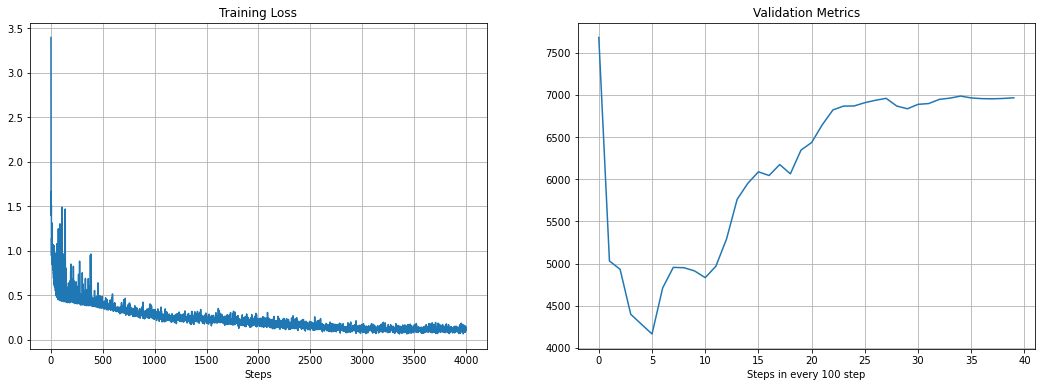

In [166]:
import matplotlib.pyplot as plt

plt.figure(figsize=[18, 6])
plt.subplot(1, 2, 1)
plt.plot(history['train_losses'])
plt.title('Training Loss')
plt.xlabel('Steps')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(history['val_metrics'])
plt.title('Validation Metrics')
plt.xlabel('Steps in every 100 step')
plt.grid()
plt.show()

## HONAM

In [163]:
from model import HONAM
honam = HONAM(
        num_features=x_train.shape[1],
        out_size=1,
        task=task,
        order=2,
        verbose=False,
        lr=0.0001,
        feature_net_dropout=0.2,
        batch_size=200,
        epochs=1000
    ).to(device)
honam.fit(x_train, y_train, x_val, y_val)

In [164]:
print('TRAIN: ', evaluate(y_train, honam.predict(x_train), task))
print('VAL: ', evaluate(y_val, honam.predict(x_val), task))
honam_pred = honam.predict(x_test)
print('TEST: ', evaluate(y_test, honam_pred, task))

TRAIN:  (0.6734530749446624, 0.4712444180285139)
VAL:  (0.42582414935942914, 0.228770256237391)
TEST:  (0.4693771582917068, 0.30607441810659686)


In [170]:
num_samples = 1000
cols = []
for i in range(len(columns)):
    X = np.zeros((num_samples, len(columns)))
    X[:, i] = np.linspace(-5.0, 5.0, num_samples)
    df = honam.feature_importance(X, [labels[c] for c in columns])
    cols.append(df.iloc[:,i])
honam_g = pd.DataFrame(cols).T
honam_g

,age,sex,body mass index,average blood pressure,total serum cholesterol,low-density lipoprotein,high-density lipoprotein,total cholesterol,lamotrigine,glucose
0,0.382001,0.275478,-0.774176,-0.999653,0.067831,0.526607,1.202081,0.011645,-0.383323,-0.028505
1,0.380657,0.274928,-0.773130,-0.997928,0.067855,0.525801,1.199746,0.011458,-0.383166,-0.028232
2,0.379313,0.274378,-0.772084,-0.996204,0.067878,0.524996,1.197412,0.011271,-0.383009,-0.027959
3,0.377969,0.273828,-0.771038,-0.994479,0.067901,0.524191,1.195077,0.011085,-0.382852,-0.027685
4,0.376625,0.273278,-0.769991,-0.992754,0.067925,0.523385,1.192743,0.010898,-0.382695,-0.027412
...,...,...,...,...,...,...,...,...,...,...
995,-0.296463,0.060823,1.437799,1.348686,0.206621,-0.432155,-0.465291,0.567680,0.130865,0.564073
996,-0.297188,0.060954,1.440447,1.351609,0.207141,-0.433017,-0.465798,0.568883,0.130910,0.565258
997,-0.297913,0.061085,1.443096,1.354531,0.207661,-0.433880,-0.466304,0.570087,0.130954,0.566443
998,-0.298638,0.061216,1.445745,1.357454,0.208181,-0.434743,-0.466811,0.571290,0.130999,0.567629


In [171]:
fig = go.Figure()
for col in honam_g.columns:
    fig.add_trace(go.Scatter(x=np.linspace(-5.0, 5.0, num_samples), y=honam_g[col], mode='lines', name=col))
fig.update_layout(height=800, yaxis=dict(title_text="Relative feature importance"), xaxis=dict(title_text="Feature values relative to the mean"), title='Global interpretation of Higher-Order NAM')
fig.show()

In [173]:
honam_local_test = honam.feature_importance(x_test, [labels[c] for c in columns])
print(honam_local_test.shape)
honam_local_test.head()

(88, 55)


,age,sex,body mass index,average blood pressure,total serum cholesterol,low-density lipoprotein,high-density lipoprotein,total cholesterol,lamotrigine,glucose,...,low-density lipoprotein*high-density lipoprotein,low-density lipoprotein*total cholesterol,low-density lipoprotein*lamotrigine,low-density lipoprotein*glucose,high-density lipoprotein*total cholesterol,high-density lipoprotein*lamotrigine,high-density lipoprotein*glucose,total cholesterol*lamotrigine,total cholesterol*glucose,lamotrigine*glucose
0,0.005756,0.073742,-0.072985,-0.076673,0.039279,-0.168068,-0.160642,0.018760,0.118372,0.017897,...,0.019747,-0.043206,0.003174,0.021684,-0.020293,-0.000940,0.019654,0.012439,0.001531,0.002210
1,-0.277232,0.073742,0.269475,0.047722,0.008726,-0.012634,-0.102722,-0.058475,-0.181399,0.074866,...,0.004303,-0.001866,-0.022401,-0.005871,-0.001066,-0.016355,0.018132,-0.011097,0.016452,-0.011566
2,-0.012757,0.009266,-0.054828,-0.063741,0.033441,-0.095530,-0.233203,-0.023833,0.123580,0.067180,...,0.024470,-0.008317,0.020956,0.002519,-0.020368,0.015599,0.029468,0.029238,0.007906,-0.009981
3,-0.277232,0.073742,0.321429,0.302864,0.007745,-0.082646,0.514494,0.159686,0.120929,0.096400,...,0.025993,-0.035736,0.014175,0.049799,-0.071741,-0.285052,0.116996,0.041283,0.069065,-0.012556
4,-0.007702,0.009266,-0.154344,-0.029146,-0.004778,-0.099692,-0.071630,0.018760,-0.071600,0.035727,...,-0.000583,-0.019065,0.025554,0.009406,-0.015825,-0.012256,0.016460,0.005249,0.001459,-0.001144


In [182]:
def get_honam_local_interpretation(index, order=1):
    if order == 1:
        _d = honam_local_test.iloc[index, :10]
        _d = _d.reset_index()
        _d.columns = ['variable', 'feature_contribution']
        _d['scaled'] = x_test[index]
        _d['original'] = preprocessor.inverse_transform_x([x_test[index]]).ravel()
        return _d
    elif order == 2:
        _d = honam_local_test.iloc[index, 10:]
        _d = _d.reset_index()
        _d.columns = ['variable', 'feature_contribution']
        _d['feat1'] = _d['variable'].str.split('*').str[0]
        _d['feat2'] = _d['variable'].str.split('*').str[1]
        _d = _d.pivot(index='feat1', columns='feat2', values='feature_contribution').reindex(columns).T.reindex(columns)
        return _d

In [192]:
honam_local = get_honam_local_interpretation(true_negative)
true = int(preprocessor.inverse_transform_y([y_test[true_negative]])[0][0])
pred = preprocessor.inverse_transform_y([honam_pred[true_negative]])[0][0]
mean = preprocessor.inverse_transform_y([[0]])[0][0]
fig = plot_local_interpretation(honam_local, f'Local interpretation of Higher-Order NAM for a sample where ACTUAL={true} | PREDICTED={pred:.2f} | MEAN={mean:.2f}')
fig.show()

In [193]:
honam_local = get_honam_local_interpretation(false_negative)
true = int(preprocessor.inverse_transform_y([y_test[false_negative]])[0][0])
pred = preprocessor.inverse_transform_y([honam_pred[false_negative]])[0][0]
mean = preprocessor.inverse_transform_y([[0]])[0][0]
fig = plot_local_interpretation(honam_local, f'Local interpretation of Higher-Order NAM for a sample where ACTUAL={true} | PREDICTED={pred:.2f} | MEAN={mean:.2f}')
fig.show()

In [194]:
honam_local = get_honam_local_interpretation(true_positive)
true = int(preprocessor.inverse_transform_y([y_test[true_positive]])[0][0])
pred = preprocessor.inverse_transform_y([honam_pred[true_positive]])[0][0]
mean = preprocessor.inverse_transform_y([[0]])[0][0]
fig = plot_local_interpretation(honam_local, f'Local interpretation of Higher-Order NAM for a sample where ACTUAL={true} | PREDICTED={pred:.2f} | MEAN={mean:.2f}')
fig.show()

In [195]:
honam_local = get_honam_local_interpretation(false_positive)
true = int(preprocessor.inverse_transform_y([y_test[false_positive]])[0][0])
pred = preprocessor.inverse_transform_y([honam_pred[false_positive]])[0][0]
mean = preprocessor.inverse_transform_y([[0]])[0][0]
fig = plot_local_interpretation(honam_local, f'Local interpretation of Higher-Order NAM for a sample where ACTUAL={true} | PREDICTED={pred:.2f} | MEAN={mean:.2f}')
fig.show()

In [ ]:
x_test[0].reshape(-1,1).dtype

In [ ]:
honam.forward(torch.from_numpy(x_test[0].reshape(-1,1)))

In [ ]:
import plotly.figure_factory as ff
fig = ff.create_distplot([y_test.ravel(), honam.predict(x_test).ravel()], ['actual', 'predicted'], show_hist=False)
fig.show()

In [ ]:
abs(-1)

In [ ]:
y_i = 100
r2 = []
r_abs = []
x = []
for y_hat in range(-50, 251):
    r2.append(1 - ((y_i - y_hat)**2 / y_i**2))
    r_abs.append(1 - (abs(y_i - y_hat) / y_i))
    x.append(y_hat)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=r2, mode='lines', name='R-squared'))
fig.add_trace(go.Scatter(x=x, y=r_abs, mode='lines', name='R-absolute'))
fig.add_vline(x=100, line_dash="dash", annotation_text="actual value", annotation_position="bottom right")
fig.update_layout(title='Change in scores with different prediction errors', xaxis_title='predicted value', yaxis_title='score', height=800)


fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=r_abs[:151], y=r2[:151], mode='lines', name='R-squared'))
# fig.update_layout(title='Change in scores with different prediction errors', xaxis_title='predicted value', yaxis_title='score')
fig.show()